In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.cluster
import torch
import tqdm
import umap

import celltrip


mpl.rcParams['pdf.fonttype'] = 42


# Load Data

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/ExpVal/expression.h5ad', backed=True)

# Model location and name
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/ExpVal-251120', 800

# Load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
adata.obs['Training'] = mask

# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')

# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');

In [ ]:
# # Read data
# adata, = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/ExpVal/expression.h5ad', backed=True)

# # Model location and name
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/ExpVal-251120', 800

In [ ]:
# # Load manager
# manager = celltrip.manager.BasicManager(
#     policy_fname=f'{prefix}-{training_step:04}.weights',
#     preprocessing_fname=f'{prefix}.pre',
#     mask_fname=f'{prefix}.mask',
#     adatas=[adata[:100]],
#     device='cuda')

In [ ]:
# # Simulate to steady state
# manager.reset_env()
# manager.simulate()
# manager.save_state('steady')

100%|██████████| 5120/5120 [00:14<00:00, 364.43it/s]


In [ ]:
# # Simulate perturbation
# manager.add_perturbation(['NAGA'], modality=0, feature_targets=0)
# time, states = manager.simulate_perturbation()

# # Revert to previous state
# manager.load_state('steady')
# manager.clear_perturbations()

100%|██████████| 1280/1280 [00:04<00:00, 313.79it/s]


# Simulate

In [4]:
# Get untreated
# sample_mask = adata.obs['age']==6  # Age 6
sample_mask = np.random.rand(adata.shape[0]) < .2  # Random 20%
# sample_mask = np.ones(adata.shape[0], dtype=bool)  # All
sim_data = adata[sample_mask].X[:]
sim_data_norm = 10_000 * sim_data / sim_data.sum(axis=1)
sim_data_pre, = preprocessing.transform([sim_data])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(sim_data_pre), compute_rewards=False, dim=32).eval(time_scale=5).to('cuda')

# Compute steady state
ret = celltrip.train.simulate_until_completion(
    env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1]
steady_state_pos = steady_state[..., :env.dim]
with torch.no_grad(): steady_state_gex = policy.pinning[0](steady_state_pos.to('cuda')).detach().cpu().numpy()
steady_state_gex, = preprocessing.inverse_transform(steady_state_gex, subset_modality=0)


0it [00:00, ?it/s]


1it [00:01,  1.91s/it]


4it [00:02,  2.51it/s]


7it [00:02,  4.79it/s]


10it [00:02,  7.25it/s]


13it [00:02,  9.77it/s]


16it [00:02, 12.19it/s]


19it [00:02, 14.36it/s]


22it [00:02, 16.23it/s]


25it [00:02, 17.75it/s]


28it [00:03, 18.95it/s]


31it [00:03, 19.85it/s]


34it [00:03, 20.53it/s]


37it [00:03, 21.03it/s]


40it [00:03, 21.39it/s]


43it [00:03, 21.62it/s]


46it [00:03, 21.82it/s]


49it [00:04, 21.95it/s]


52it [00:04, 22.05it/s]


55it [00:04, 22.08it/s]


58it [00:04, 22.15it/s]


61it [00:04, 22.18it/s]


64it [00:04, 22.20it/s]


67it [00:04, 22.22it/s]


70it [00:05, 22.25it/s]


73it [00:05, 22.27it/s]


76it [00:05, 22.29it/s]


79it [00:05, 22.25it/s]


82it [00:05, 22.26it/s]


85it [00:05, 22.27it/s]


88it [00:05, 22.27it/s]


91it [00:05, 22.27it/s]


94it [00:06, 22.28it/s]


97it [00:06, 22.28it/s]


100it [00:06, 22.13it/s]


103it [00:06, 22.18it/s]


106it [00:06, 22.20it/s]


109it [00:06, 22.22it/s]


112it [00:06, 22.24it/s]


115it [00:07, 22.25it/s]


118it [00:07, 22.27it/s]


121it [00:07, 22.26it/s]


124it [00:07, 22.26it/s]


127it [00:07, 22.26it/s]


130it [00:07, 22.30it/s]


133it [00:07, 22.30it/s]


136it [00:07, 22.30it/s]


139it [00:08, 22.31it/s]


142it [00:08, 22.30it/s]


145it [00:08, 22.29it/s]


148it [00:08, 22.29it/s]


151it [00:08, 22.28it/s]


154it [00:08, 22.27it/s]


157it [00:08, 22.28it/s]


160it [00:09, 22.27it/s]


163it [00:09, 22.28it/s]


166it [00:09, 22.28it/s]


169it [00:09, 22.28it/s]


172it [00:09, 22.27it/s]


175it [00:09, 22.28it/s]


178it [00:09, 22.27it/s]


181it [00:10, 22.27it/s]


184it [00:10, 22.28it/s]


187it [00:10, 22.28it/s]


190it [00:10, 22.26it/s]


193it [00:10, 22.28it/s]


196it [00:10, 22.20it/s]


199it [00:10, 22.22it/s]


202it [00:10, 22.10it/s]


205it [00:11, 22.14it/s]


208it [00:11, 22.16it/s]


211it [00:11, 22.17it/s]


214it [00:11, 22.21it/s]


217it [00:11, 22.23it/s]


220it [00:11, 22.25it/s]


223it [00:11, 22.26it/s]


226it [00:12, 22.27it/s]


229it [00:12, 22.27it/s]


232it [00:12, 22.25it/s]


235it [00:12, 22.26it/s]


238it [00:12, 22.27it/s]


241it [00:12, 22.27it/s]


244it [00:12, 22.22it/s]


247it [00:12, 22.21it/s]


250it [00:13, 22.20it/s]


253it [00:13, 22.20it/s]


256it [00:13, 22.12it/s]


259it [00:13, 22.15it/s]


262it [00:13, 22.19it/s]


265it [00:13, 22.20it/s]


268it [00:13, 22.23it/s]


271it [00:14, 22.22it/s]


274it [00:14, 22.20it/s]


277it [00:14, 22.17it/s]


280it [00:14, 22.17it/s]


283it [00:14, 22.16it/s]


286it [00:14, 22.18it/s]


289it [00:14, 22.20it/s]


292it [00:15, 22.21it/s]


295it [00:15, 22.19it/s]


298it [00:15, 22.19it/s]


301it [00:15, 22.03it/s]


304it [00:15, 22.07it/s]


307it [00:15, 22.11it/s]


310it [00:15, 22.15it/s]


313it [00:15, 22.17it/s]


316it [00:16, 22.17it/s]


319it [00:16, 22.21it/s]


322it [00:16, 22.20it/s]


325it [00:16, 22.21it/s]


328it [00:16, 22.20it/s]


331it [00:16, 22.22it/s]


334it [00:16, 22.22it/s]


337it [00:17, 22.22it/s]


340it [00:17, 22.23it/s]


343it [00:17, 22.19it/s]


346it [00:17, 22.21it/s]


349it [00:17, 22.23it/s]


352it [00:17, 22.25it/s]


355it [00:17, 22.26it/s]


358it [00:17, 22.27it/s]


361it [00:18, 22.29it/s]


364it [00:18, 22.28it/s]


367it [00:18, 22.28it/s]


370it [00:18, 22.29it/s]


373it [00:18, 22.30it/s]


376it [00:18, 22.31it/s]


379it [00:18, 22.33it/s]


382it [00:19, 22.32it/s]


385it [00:19, 22.32it/s]


388it [00:19, 22.30it/s]


391it [00:19, 22.30it/s]


394it [00:19, 22.31it/s]


397it [00:19, 22.32it/s]


400it [00:19, 22.19it/s]


403it [00:19, 22.23it/s]


406it [00:20, 22.25it/s]


409it [00:20, 22.28it/s]


412it [00:20, 22.29it/s]


415it [00:20, 22.30it/s]


418it [00:20, 22.30it/s]


421it [00:20, 22.26it/s]


424it [00:20, 22.27it/s]


427it [00:21, 22.29it/s]


430it [00:21, 22.30it/s]


433it [00:21, 22.30it/s]


436it [00:21, 22.31it/s]


439it [00:21, 22.31it/s]


442it [00:21, 22.31it/s]


445it [00:21, 22.33it/s]


448it [00:22, 22.33it/s]


451it [00:22, 22.32it/s]


454it [00:22, 22.31it/s]


457it [00:22, 22.32it/s]


460it [00:22, 22.32it/s]


463it [00:22, 22.33it/s]


466it [00:22, 22.32it/s]


469it [00:22, 22.32it/s]


472it [00:23, 22.33it/s]


475it [00:23, 22.32it/s]


478it [00:23, 22.30it/s]


481it [00:23, 22.27it/s]


484it [00:23, 22.27it/s]


487it [00:23, 22.26it/s]


490it [00:23, 22.26it/s]


493it [00:24, 22.28it/s]


496it [00:24, 22.28it/s]


499it [00:24, 22.26it/s]


502it [00:24, 22.14it/s]


505it [00:24, 22.19it/s]


508it [00:24, 22.22it/s]


511it [00:24, 22.24it/s]


514it [00:24, 22.27it/s]


517it [00:25, 22.29it/s]


520it [00:25, 22.30it/s]


523it [00:25, 22.28it/s]


526it [00:25, 22.29it/s]


529it [00:25, 22.29it/s]


532it [00:25, 22.30it/s]


535it [00:25, 22.30it/s]


538it [00:26, 22.30it/s]


541it [00:26, 22.28it/s]


544it [00:26, 22.28it/s]


547it [00:26, 22.29it/s]


550it [00:26, 22.28it/s]


553it [00:26, 22.28it/s]


556it [00:26, 22.26it/s]


559it [00:26, 22.28it/s]


562it [00:27, 22.28it/s]


565it [00:27, 22.28it/s]


568it [00:27, 22.28it/s]


571it [00:27, 22.26it/s]


574it [00:27, 22.27it/s]


577it [00:27, 22.29it/s]


580it [00:27, 22.28it/s]


583it [00:28, 22.29it/s]


586it [00:28, 22.30it/s]


589it [00:28, 22.29it/s]


592it [00:28, 22.30it/s]


595it [00:28, 22.30it/s]


598it [00:28, 22.29it/s]


601it [00:28, 22.18it/s]


604it [00:29, 22.21it/s]


607it [00:29, 22.24it/s]


610it [00:29, 22.24it/s]


613it [00:29, 22.26it/s]


616it [00:29, 22.28it/s]


619it [00:29, 22.30it/s]


622it [00:29, 22.31it/s]


625it [00:29, 22.30it/s]


628it [00:30, 22.31it/s]


631it [00:30, 22.30it/s]


634it [00:30, 22.29it/s]


637it [00:30, 22.30it/s]


640it [00:30, 22.28it/s]


643it [00:30, 22.29it/s]


646it [00:30, 22.30it/s]


649it [00:31, 22.30it/s]


652it [00:31, 22.31it/s]


655it [00:31, 22.31it/s]


658it [00:31, 22.23it/s]


661it [00:31, 22.21it/s]


664it [00:31, 22.23it/s]


667it [00:31, 22.21it/s]


670it [00:31, 22.21it/s]


673it [00:32, 22.22it/s]


676it [00:32, 22.24it/s]


679it [00:32, 22.27it/s]


682it [00:32, 22.28it/s]


685it [00:32, 22.25it/s]


688it [00:32, 22.27it/s]


691it [00:32, 22.28it/s]


694it [00:33, 22.28it/s]


697it [00:33, 22.30it/s]


700it [00:33, 22.17it/s]


703it [00:33, 22.19it/s]


706it [00:33, 22.22it/s]


709it [00:33, 22.25it/s]


712it [00:33, 22.26it/s]


715it [00:33, 22.27it/s]


718it [00:34, 22.28it/s]


721it [00:34, 22.29it/s]


724it [00:34, 22.28it/s]


727it [00:34, 22.29it/s]


730it [00:34, 22.30it/s]


733it [00:34, 22.30it/s]


736it [00:34, 22.28it/s]


739it [00:35, 22.29it/s]


742it [00:35, 22.28it/s]


745it [00:35, 22.27it/s]


748it [00:35, 22.29it/s]


751it [00:35, 22.30it/s]


754it [00:35, 22.29it/s]


757it [00:35, 22.29it/s]


760it [00:36, 22.29it/s]


763it [00:36, 22.31it/s]


766it [00:36, 22.30it/s]


769it [00:36, 22.33it/s]


772it [00:36, 22.33it/s]


775it [00:36, 22.32it/s]


778it [00:36, 22.32it/s]


781it [00:36, 22.32it/s]


784it [00:37, 22.32it/s]


787it [00:37, 22.32it/s]


790it [00:37, 22.30it/s]


793it [00:37, 22.30it/s]


796it [00:37, 22.28it/s]


799it [00:37, 22.30it/s]


802it [00:37, 22.19it/s]


805it [00:38, 22.22it/s]


808it [00:38, 22.24it/s]


811it [00:38, 22.27it/s]


814it [00:38, 22.28it/s]


817it [00:38, 22.25it/s]


820it [00:38, 22.11it/s]


823it [00:38, 22.13it/s]


826it [00:38, 22.14it/s]


829it [00:39, 22.16it/s]


832it [00:39, 22.19it/s]


835it [00:39, 22.20it/s]


838it [00:39, 22.23it/s]


841it [00:39, 22.27it/s]


844it [00:39, 22.30it/s]


847it [00:39, 22.30it/s]


850it [00:40, 22.30it/s]


853it [00:40, 22.31it/s]


856it [00:40, 22.30it/s]


859it [00:40, 22.30it/s]


862it [00:40, 22.30it/s]


865it [00:40, 22.29it/s]


868it [00:40, 22.29it/s]


871it [00:41, 22.28it/s]


874it [00:41, 22.28it/s]


877it [00:41, 22.30it/s]


880it [00:41, 22.25it/s]


883it [00:41, 22.27it/s]


886it [00:41, 22.27it/s]


889it [00:41, 22.24it/s]


892it [00:41, 22.26it/s]


895it [00:42, 22.29it/s]


898it [00:42, 22.30it/s]


901it [00:42, 22.16it/s]


904it [00:42, 22.16it/s]


907it [00:42, 22.19it/s]


910it [00:42, 22.22it/s]


913it [00:42, 22.25it/s]


916it [00:43, 22.26it/s]


919it [00:43, 22.26it/s]


922it [00:43, 22.26it/s]


925it [00:43, 22.25it/s]


928it [00:43, 22.25it/s]


931it [00:43, 22.27it/s]


934it [00:43, 22.28it/s]


937it [00:43, 22.27it/s]


940it [00:44, 22.27it/s]


943it [00:44, 22.27it/s]


946it [00:44, 22.26it/s]


949it [00:44, 22.27it/s]


952it [00:44, 22.28it/s]


955it [00:44, 22.27it/s]


958it [00:44, 22.27it/s]


961it [00:45, 22.26it/s]


964it [00:45, 22.27it/s]


967it [00:45, 22.23it/s]


970it [00:45, 22.21it/s]


973it [00:45, 22.22it/s]


976it [00:45, 22.22it/s]


979it [00:45, 22.23it/s]


982it [00:45, 22.21it/s]


985it [00:46, 22.20it/s]


988it [00:46, 22.22it/s]


991it [00:46, 22.21it/s]


994it [00:46, 22.21it/s]


997it [00:46, 22.23it/s]


1000it [00:46, 22.12it/s]


1003it [00:46, 22.14it/s]


1006it [00:47, 22.18it/s]


1009it [00:47, 22.20it/s]


1012it [00:47, 22.19it/s]


1015it [00:47, 22.21it/s]


1018it [00:47, 22.22it/s]


1021it [00:47, 22.18it/s]


1024it [00:47, 22.20it/s]


1027it [00:48, 22.21it/s]


1030it [00:48, 22.23it/s]


1033it [00:48, 22.25it/s]


1036it [00:48, 22.25it/s]


1039it [00:48, 22.26it/s]


1042it [00:48, 22.25it/s]


1045it [00:48, 22.25it/s]


1048it [00:48, 22.26it/s]


1051it [00:49, 22.21it/s]


1054it [00:49, 22.22it/s]


1057it [00:49, 22.23it/s]


1060it [00:49, 22.24it/s]


1063it [00:49, 22.27it/s]


1066it [00:49, 22.27it/s]


1069it [00:49, 22.28it/s]


1072it [00:50, 22.26it/s]


1075it [00:50, 22.28it/s]


1078it [00:50, 22.26it/s]


1081it [00:50, 22.27it/s]


1084it [00:50, 22.28it/s]


1087it [00:50, 22.28it/s]


1090it [00:50, 22.28it/s]


1093it [00:50, 22.29it/s]


1096it [00:51, 22.27it/s]


1099it [00:51, 22.28it/s]


1102it [00:51, 22.15it/s]


1105it [00:51, 22.17it/s]


1108it [00:51, 22.18it/s]


1111it [00:51, 22.20it/s]


1114it [00:51, 22.23it/s]


1117it [00:52, 22.24it/s]


1120it [00:52, 22.25it/s]


1123it [00:52, 22.22it/s]


1126it [00:52, 22.21it/s]


1129it [00:52, 22.23it/s]


1132it [00:52, 22.25it/s]


1135it [00:52, 22.26it/s]


1138it [00:53, 22.27it/s]


1141it [00:53, 22.27it/s]


1144it [00:53, 22.26it/s]


1147it [00:53, 22.21it/s]


1150it [00:53, 22.21it/s]


1153it [00:53, 22.23it/s]


1156it [00:53, 22.24it/s]


1159it [00:53, 22.25it/s]


1162it [00:54, 22.25it/s]


1165it [00:54, 22.25it/s]


1168it [00:54, 22.23it/s]


1171it [00:54, 22.25it/s]


1174it [00:54, 22.23it/s]


1177it [00:54, 22.24it/s]


1180it [00:54, 22.25it/s]


1183it [00:55, 22.21it/s]


1186it [00:55, 22.20it/s]


1189it [00:55, 22.20it/s]


1192it [00:55, 22.22it/s]


1195it [00:55, 22.25it/s]


1198it [00:55, 22.27it/s]


1201it [00:55, 22.16it/s]


1204it [00:55, 22.21it/s]


1207it [00:56, 22.25it/s]


1210it [00:56, 22.27it/s]


1213it [00:56, 22.26it/s]


1216it [00:56, 22.26it/s]


1219it [00:56, 22.27it/s]


1222it [00:56, 22.28it/s]


1225it [00:56, 22.29it/s]


1228it [00:57, 22.29it/s]


1231it [00:57, 22.30it/s]


1234it [00:57, 22.28it/s]


1237it [00:57, 22.28it/s]


1240it [00:57, 22.28it/s]


1243it [00:57, 22.25it/s]


1246it [00:57, 22.25it/s]


1249it [00:57, 22.27it/s]


1252it [00:58, 22.28it/s]


1255it [00:58, 22.26it/s]


1258it [00:58, 22.27it/s]


1261it [00:58, 22.28it/s]


1264it [00:58, 22.28it/s]


1267it [00:58, 22.29it/s]


1270it [00:58, 22.27it/s]


1273it [00:59, 22.26it/s]


1276it [00:59, 22.26it/s]


1279it [00:59, 22.25it/s]


1282it [00:59, 22.24it/s]


1285it [00:59, 22.26it/s]


1288it [00:59, 22.27it/s]


1291it [00:59, 22.27it/s]


1294it [01:00, 22.27it/s]


1297it [01:00, 22.27it/s]


1300it [01:00, 22.15it/s]


1303it [01:00, 22.19it/s]


1306it [01:00, 22.22it/s]


1309it [01:00, 22.23it/s]


1312it [01:00, 22.25it/s]


1315it [01:00, 22.25it/s]


1318it [01:01, 22.26it/s]


1321it [01:01, 22.28it/s]


1324it [01:01, 22.26it/s]


1327it [01:01, 22.26it/s]


1330it [01:01, 22.27it/s]


1333it [01:01, 22.26it/s]


1336it [01:01, 22.28it/s]


1339it [01:02, 22.28it/s]


1342it [01:02, 22.28it/s]


1345it [01:02, 22.25it/s]


1348it [01:02, 22.27it/s]


1351it [01:02, 22.27it/s]


1354it [01:02, 22.27it/s]


1357it [01:02, 22.27it/s]


1360it [01:02, 22.27it/s]


1363it [01:03, 22.27it/s]


1366it [01:03, 22.26it/s]


1369it [01:03, 22.26it/s]


1372it [01:03, 22.28it/s]


1375it [01:03, 22.29it/s]


1378it [01:03, 22.30it/s]


1381it [01:03, 22.30it/s]


1384it [01:04, 22.30it/s]


1387it [01:04, 22.30it/s]


1390it [01:04, 22.28it/s]


1393it [01:04, 22.30it/s]


1396it [01:04, 22.27it/s]


1399it [01:04, 22.26it/s]


1402it [01:04, 22.13it/s]


1405it [01:05, 22.18it/s]


1408it [01:05, 22.21it/s]


1411it [01:05, 22.23it/s]


1414it [01:05, 22.24it/s]


1417it [01:05, 22.26it/s]


1420it [01:05, 22.26it/s]


1423it [01:05, 22.27it/s]


1426it [01:05, 22.27it/s]


1429it [01:06, 22.29it/s]


1432it [01:06, 22.29it/s]


1435it [01:06, 22.28it/s]


1438it [01:06, 22.28it/s]


1441it [01:06, 22.26it/s]


1444it [01:06, 22.25it/s]


1447it [01:06, 22.26it/s]


1450it [01:07, 22.26it/s]


1453it [01:07, 22.27it/s]


1456it [01:07, 22.26it/s]


1459it [01:07, 22.26it/s]


1462it [01:07, 22.28it/s]


1465it [01:07, 22.28it/s]


1468it [01:07, 22.28it/s]


1471it [01:07, 22.28it/s]


1474it [01:08, 22.28it/s]


1477it [01:08, 22.28it/s]


1480it [01:08, 22.28it/s]


1483it [01:08, 22.29it/s]


1486it [01:08, 22.28it/s]


1489it [01:08, 22.24it/s]


1492it [01:08, 22.26it/s]


1495it [01:09, 22.24it/s]


1498it [01:09, 22.24it/s]


1501it [01:09, 22.10it/s]


1504it [01:09, 22.15it/s]


1507it [01:09, 22.18it/s]


1510it [01:09, 22.21it/s]


1513it [01:09, 22.22it/s]


1516it [01:09, 22.22it/s]


1519it [01:10, 22.23it/s]


1522it [01:10, 22.21it/s]


1525it [01:10, 22.23it/s]


1528it [01:10, 22.24it/s]


1531it [01:10, 22.23it/s]


1534it [01:10, 22.24it/s]


1537it [01:10, 22.25it/s]


1540it [01:11, 22.26it/s]


1543it [01:11, 22.26it/s]


1546it [01:11, 22.24it/s]


1549it [01:11, 22.25it/s]


1552it [01:11, 22.24it/s]


1555it [01:11, 22.25it/s]


1558it [01:11, 22.26it/s]


1561it [01:12, 22.27it/s]


1564it [01:12, 22.28it/s]


1567it [01:12, 22.27it/s]


1570it [01:12, 22.25it/s]


1573it [01:12, 22.25it/s]


1576it [01:12, 22.26it/s]


1579it [01:12, 22.25it/s]


1582it [01:12, 22.25it/s]


1585it [01:13, 22.27it/s]


1588it [01:13, 22.26it/s]


1591it [01:13, 22.22it/s]


1594it [01:13, 22.24it/s]


1597it [01:13, 22.25it/s]


1600it [01:13, 22.13it/s]


1603it [01:13, 22.16it/s]


1606it [01:14, 22.20it/s]


1609it [01:14, 22.23it/s]


1612it [01:14, 22.22it/s]


1615it [01:14, 22.24it/s]


1618it [01:14, 22.26it/s]


1621it [01:14, 22.25it/s]


1624it [01:14, 22.26it/s]


1627it [01:14, 22.26it/s]


1630it [01:15, 22.28it/s]


1633it [01:15, 22.26it/s]


1636it [01:15, 22.24it/s]


1639it [01:15, 22.26it/s]


1642it [01:15, 22.26it/s]


1645it [01:15, 22.27it/s]


1648it [01:15, 22.27it/s]


1651it [01:16, 22.28it/s]


1654it [01:16, 22.29it/s]


1657it [01:16, 22.26it/s]


1660it [01:16, 22.27it/s]


1663it [01:16, 22.28it/s]


1666it [01:16, 22.29it/s]


1669it [01:16, 22.28it/s]


1672it [01:17, 22.27it/s]


1675it [01:17, 22.24it/s]


1678it [01:17, 22.26it/s]


1681it [01:17, 22.25it/s]


1684it [01:17, 22.25it/s]


1687it [01:17, 22.26it/s]


1690it [01:17, 22.26it/s]


1693it [01:17, 22.27it/s]


1696it [01:18, 22.27it/s]


1699it [01:18, 22.28it/s]


1702it [01:18, 22.15it/s]


1705it [01:18, 22.19it/s]


1708it [01:18, 22.21it/s]


1711it [01:18, 22.23it/s]


1714it [01:18, 22.24it/s]


1717it [01:19, 22.24it/s]


1720it [01:19, 22.26it/s]


1723it [01:19, 22.25it/s]


1726it [01:19, 22.26it/s]


1729it [01:19, 22.28it/s]


1732it [01:19, 22.26it/s]


1735it [01:19, 22.26it/s]


1738it [01:19, 22.26it/s]


1741it [01:20, 22.27it/s]


1744it [01:20, 22.27it/s]


1747it [01:20, 22.26it/s]


1750it [01:20, 22.26it/s]


1753it [01:20, 22.27it/s]


1756it [01:20, 22.24it/s]


1759it [01:20, 22.24it/s]


1762it [01:21, 22.25it/s]


1765it [01:21, 22.26it/s]


1768it [01:21, 22.25it/s]


1771it [01:21, 22.26it/s]


1774it [01:21, 22.24it/s]


1777it [01:21, 22.24it/s]


1780it [01:21, 22.24it/s]


1783it [01:21, 22.25it/s]


1786it [01:22, 22.26it/s]


1789it [01:22, 22.27it/s]


1792it [01:22, 22.27it/s]


1795it [01:22, 22.27it/s]


1798it [01:22, 22.27it/s]


1801it [01:22, 22.14it/s]


1804it [01:22, 22.19it/s]


1807it [01:23, 22.20it/s]


1810it [01:23, 22.23it/s]


1813it [01:23, 22.22it/s]


1816it [01:23, 22.23it/s]


1819it [01:23, 22.25it/s]


1822it [01:23, 22.24it/s]


1825it [01:23, 22.28it/s]


1828it [01:24, 22.28it/s]


1831it [01:24, 22.28it/s]


1834it [01:24, 22.27it/s]


1837it [01:24, 22.28it/s]


1840it [01:24, 22.28it/s]


1843it [01:24, 22.27it/s]


1846it [01:24, 22.26it/s]


1849it [01:24, 22.26it/s]


1852it [01:25, 22.25it/s]


1855it [01:25, 22.25it/s]


1858it [01:25, 22.24it/s]


1861it [01:25, 22.25it/s]


1864it [01:25, 22.24it/s]


1867it [01:25, 22.25it/s]


1870it [01:25, 22.27it/s]


1873it [01:26, 22.26it/s]


1876it [01:26, 22.26it/s]


1879it [01:26, 22.26it/s]


1882it [01:26, 22.28it/s]


1885it [01:26, 22.28it/s]


1888it [01:26, 22.27it/s]


1891it [01:26, 22.28it/s]


1894it [01:26, 22.28it/s]


1897it [01:27, 22.27it/s]


1900it [01:27, 22.16it/s]


1903it [01:27, 22.18it/s]


1906it [01:27, 22.20it/s]


1909it [01:27, 22.22it/s]


1912it [01:27, 22.24it/s]


1915it [01:27, 22.26it/s]


1918it [01:28, 22.27it/s]


1921it [01:28, 22.27it/s]


1924it [01:28, 22.26it/s]


1927it [01:28, 22.28it/s]


1930it [01:28, 22.26it/s]


1933it [01:28, 22.27it/s]


1936it [01:28, 22.27it/s]


1939it [01:29, 22.27it/s]


1942it [01:29, 22.26it/s]


1945it [01:29, 22.26it/s]


1948it [01:29, 22.26it/s]


1951it [01:29, 22.28it/s]


1954it [01:29, 22.27it/s]


1957it [01:29, 22.28it/s]


1960it [01:29, 22.27it/s]


1963it [01:30, 22.27it/s]


1966it [01:30, 22.28it/s]


1969it [01:30, 22.29it/s]


1972it [01:30, 22.29it/s]


1975it [01:30, 22.29it/s]


1978it [01:30, 22.29it/s]


1981it [01:30, 22.27it/s]


1984it [01:31, 22.27it/s]


1987it [01:31, 22.27it/s]


1990it [01:31, 22.26it/s]


1993it [01:31, 22.26it/s]


1996it [01:31, 22.26it/s]


1999it [01:31, 22.26it/s]


2002it [01:31, 22.15it/s]


2005it [01:31, 22.18it/s]


2008it [01:32, 22.21it/s]


2011it [01:32, 22.22it/s]


2014it [01:32, 22.22it/s]


2017it [01:32, 22.23it/s]


2020it [01:32, 22.24it/s]


2023it [01:32, 22.22it/s]


2026it [01:32, 22.23it/s]


2029it [01:33, 22.25it/s]


2032it [01:33, 22.25it/s]


2035it [01:33, 22.24it/s]


2038it [01:33, 22.25it/s]


2041it [01:33, 22.25it/s]


2044it [01:33, 22.24it/s]


2047it [01:33, 22.26it/s]


2050it [01:33, 22.25it/s]


2053it [01:34, 22.25it/s]


2056it [01:34, 22.24it/s]


2059it [01:34, 22.25it/s]


2062it [01:34, 22.25it/s]


2065it [01:34, 22.26it/s]


2068it [01:34, 22.27it/s]


2071it [01:34, 22.27it/s]


2074it [01:35, 22.28it/s]


2077it [01:35, 22.27it/s]


2080it [01:35, 22.24it/s]


2083it [01:35, 22.24it/s]


2086it [01:35, 22.26it/s]


2089it [01:35, 22.26it/s]


2092it [01:35, 22.28it/s]


2095it [01:36, 22.28it/s]


2098it [01:36, 22.27it/s]


2101it [01:36, 22.17it/s]


2104it [01:36, 22.20it/s]


2107it [01:36, 22.22it/s]


2110it [01:36, 22.22it/s]


2113it [01:36, 22.23it/s]


2116it [01:36, 22.25it/s]


2119it [01:37, 22.26it/s]


2122it [01:37, 22.26it/s]


2125it [01:37, 22.26it/s]


2128it [01:37, 22.25it/s]


2131it [01:37, 22.25it/s]


2134it [01:37, 22.27it/s]


2137it [01:37, 22.27it/s]


2140it [01:38, 22.26it/s]


2143it [01:38, 22.27it/s]


2146it [01:38, 22.24it/s]


2149it [01:38, 22.26it/s]


2152it [01:38, 22.26it/s]


2155it [01:38, 22.27it/s]


2158it [01:38, 22.27it/s]


2161it [01:38, 22.27it/s]


2164it [01:39, 22.27it/s]


2167it [01:39, 22.26it/s]


2170it [01:39, 22.26it/s]


2173it [01:39, 22.25it/s]


2176it [01:39, 22.27it/s]


2179it [01:39, 22.28it/s]


2182it [01:39, 22.28it/s]


2185it [01:40, 22.28it/s]


2188it [01:40, 22.29it/s]


2191it [01:40, 22.28it/s]


2194it [01:40, 22.28it/s]


2197it [01:40, 22.28it/s]


2200it [01:40, 22.15it/s]


2203it [01:40, 22.17it/s]


2206it [01:41, 22.19it/s]


2209it [01:41, 22.21it/s]


2212it [01:41, 22.24it/s]


2215it [01:41, 22.23it/s]


2218it [01:41, 22.24it/s]


2221it [01:41, 22.25it/s]


2224it [01:41, 22.27it/s]


2227it [01:41, 22.27it/s]


2230it [01:42, 22.28it/s]


2233it [01:42, 22.28it/s]


2236it [01:42, 22.26it/s]


2239it [01:42, 22.26it/s]


2242it [01:42, 22.26it/s]


2245it [01:42, 22.27it/s]


2248it [01:42, 22.28it/s]


2251it [01:43, 22.28it/s]


2254it [01:43, 22.29it/s]


2257it [01:43, 22.26it/s]


2260it [01:43, 22.26it/s]


2263it [01:43, 22.25it/s]


2266it [01:43, 22.26it/s]


2269it [01:43, 22.26it/s]


2272it [01:43, 22.27it/s]


2275it [01:44, 22.28it/s]


2278it [01:44, 22.28it/s]


2281it [01:44, 22.27it/s]


2284it [01:44, 22.27it/s]


2287it [01:44, 22.28it/s]


2290it [01:44, 22.27it/s]


2293it [01:44, 22.27it/s]


2296it [01:45, 22.27it/s]


2299it [01:45, 22.28it/s]


2302it [01:45, 22.14it/s]


2305it [01:45, 22.18it/s]


2308it [01:45, 22.20it/s]


2311it [01:45, 22.23it/s]


2314it [01:45, 22.24it/s]


2317it [01:45, 22.26it/s]


2320it [01:46, 22.25it/s]


2323it [01:46, 22.27it/s]


2326it [01:46, 22.21it/s]


2329it [01:46, 22.24it/s]


2332it [01:46, 22.25it/s]


2335it [01:46, 22.25it/s]


2338it [01:46, 22.27it/s]


2341it [01:47, 22.26it/s]


2344it [01:47, 22.26it/s]


2347it [01:47, 22.24it/s]


2350it [01:47, 22.24it/s]


2353it [01:47, 22.25it/s]


2356it [01:47, 22.25it/s]


2359it [01:47, 22.26it/s]


2362it [01:48, 22.26it/s]


2365it [01:48, 22.26it/s]


2368it [01:48, 22.25it/s]


2371it [01:48, 22.26it/s]


2374it [01:48, 22.28it/s]


2377it [01:48, 22.27it/s]


2380it [01:48, 22.28it/s]


2383it [01:48, 22.29it/s]


2386it [01:49, 22.28it/s]


2389it [01:49, 22.29it/s]


2392it [01:49, 22.29it/s]


2395it [01:49, 22.27it/s]


2398it [01:49, 22.27it/s]


2401it [01:49, 22.16it/s]


2404it [01:49, 22.20it/s]


2407it [01:50, 22.22it/s]


2410it [01:50, 22.24it/s]


2413it [01:50, 22.24it/s]


2416it [01:50, 22.25it/s]


2419it [01:50, 22.24it/s]


2422it [01:50, 22.25it/s]


2425it [01:50, 22.26it/s]


2428it [01:50, 22.24it/s]


2431it [01:51, 22.24it/s]


2434it [01:51, 22.24it/s]


2437it [01:51, 22.24it/s]


2440it [01:51, 22.25it/s]


2443it [01:51, 22.25it/s]


2446it [01:51, 22.26it/s]


2449it [01:51, 22.26it/s]


2452it [01:52, 22.27it/s]


2455it [01:52, 22.26it/s]


2458it [01:52, 22.24it/s]


2461it [01:52, 22.26it/s]


2464it [01:52, 22.26it/s]


2467it [01:52, 22.27it/s]


2470it [01:52, 22.27it/s]


2473it [01:53, 22.28it/s]


2476it [01:53, 22.27it/s]


2479it [01:53, 22.25it/s]


2482it [01:53, 22.27it/s]


2485it [01:53, 22.27it/s]


2488it [01:53, 22.27it/s]


2491it [01:53, 22.26it/s]


2494it [01:53, 22.28it/s]


2497it [01:54, 22.28it/s]


2500it [01:54, 22.16it/s]


2503it [01:54, 22.17it/s]


2506it [01:54, 22.21it/s]


2509it [01:54, 22.22it/s]


2512it [01:54, 22.22it/s]


2515it [01:54, 22.25it/s]


2518it [01:55, 22.26it/s]


2521it [01:55, 22.25it/s]


2524it [01:55, 22.24it/s]


2527it [01:55, 22.24it/s]


2530it [01:55, 22.25it/s]


2533it [01:55, 22.26it/s]


2536it [01:55, 22.26it/s]


2539it [01:55, 22.27it/s]


2542it [01:56, 22.27it/s]


2545it [01:56, 22.28it/s]


2548it [01:56, 22.25it/s]


2551it [01:56, 22.26it/s]


2554it [01:56, 22.26it/s]


2557it [01:56, 22.26it/s]


2560it [01:56, 22.28it/s]


2563it [01:57, 22.27it/s]


2566it [01:57, 22.26it/s]


2569it [01:57, 22.26it/s]


2572it [01:57, 22.26it/s]


2575it [01:57, 22.27it/s]


2578it [01:57, 22.27it/s]


2581it [01:57, 22.28it/s]


2584it [01:57, 22.27it/s]


2587it [01:58, 22.27it/s]


2590it [01:58, 22.25it/s]


2593it [01:58, 22.26it/s]


2596it [01:58, 22.25it/s]


2599it [01:58, 22.27it/s]


2602it [01:58, 22.15it/s]


2605it [01:58, 22.19it/s]


2608it [01:59, 22.21it/s]


2611it [01:59, 22.23it/s]


2614it [01:59, 22.23it/s]


2617it [01:59, 22.24it/s]


2620it [01:59, 22.23it/s]


2623it [01:59, 22.24it/s]


2626it [01:59, 22.26it/s]


2629it [02:00, 22.26it/s]


2632it [02:00, 22.27it/s]


2635it [02:00, 22.27it/s]


2638it [02:00, 22.26it/s]


2641it [02:00, 22.27it/s]


2644it [02:00, 22.27it/s]


2647it [02:00, 22.26it/s]


2650it [02:00, 22.26it/s]


2653it [02:01, 22.26it/s]


2656it [02:01, 22.27it/s]


2659it [02:01, 22.26it/s]


2662it [02:01, 22.26it/s]


2665it [02:01, 22.27it/s]


2668it [02:01, 22.25it/s]


2671it [02:01, 22.25it/s]


2674it [02:02, 22.27it/s]


2677it [02:02, 22.26it/s]


2680it [02:02, 22.25it/s]


2683it [02:02, 22.27it/s]


2686it [02:02, 22.26it/s]


2689it [02:02, 22.26it/s]


2692it [02:02, 22.25it/s]


2695it [02:02, 22.27it/s]


2698it [02:03, 22.25it/s]


2701it [02:03, 22.12it/s]


2704it [02:03, 22.17it/s]


2707it [02:03, 22.20it/s]


2710it [02:03, 22.22it/s]


2713it [02:03, 22.23it/s]


2716it [02:03, 22.25it/s]


2719it [02:04, 22.26it/s]


2722it [02:04, 22.25it/s]


2725it [02:04, 22.25it/s]


2728it [02:04, 22.25it/s]


2731it [02:04, 22.24it/s]


2734it [02:04, 22.25it/s]


2737it [02:04, 22.25it/s]


2740it [02:05, 22.27it/s]


2743it [02:05, 22.22it/s]


2746it [02:05, 22.24it/s]


2749it [02:05, 22.21it/s]


2752it [02:05, 22.23it/s]


2755it [02:05, 22.23it/s]


2758it [02:05, 22.25it/s]


2761it [02:05, 22.26it/s]


2764it [02:06, 22.25it/s]


2767it [02:06, 22.25it/s]


2770it [02:06, 22.23it/s]


2773it [02:06, 22.25it/s]


2776it [02:06, 22.25it/s]


2779it [02:06, 22.26it/s]


2782it [02:06, 22.26it/s]


2785it [02:07, 22.25it/s]


2788it [02:07, 22.24it/s]


2791it [02:07, 22.24it/s]


2794it [02:07, 22.25it/s]


2797it [02:07, 22.25it/s]


2800it [02:07, 22.14it/s]


2803it [02:07, 22.17it/s]


2806it [02:07, 22.20it/s]


2809it [02:08, 22.23it/s]


2812it [02:08, 22.24it/s]


2815it [02:08, 22.23it/s]


2818it [02:08, 22.23it/s]


2821it [02:08, 22.24it/s]


2824it [02:08, 22.24it/s]


2827it [02:08, 22.25it/s]


2830it [02:09, 22.25it/s]


2833it [02:09, 22.25it/s]


2836it [02:09, 22.25it/s]


2839it [02:09, 22.23it/s]


2842it [02:09, 22.26it/s]


2845it [02:09, 22.24it/s]


2848it [02:09, 22.24it/s]


2851it [02:09, 22.25it/s]


2854it [02:10, 22.26it/s]


2857it [02:10, 22.27it/s]


2860it [02:10, 22.26it/s]


2863it [02:10, 22.27it/s]


2866it [02:10, 22.23it/s]


2869it [02:10, 22.21it/s]


2872it [02:10, 22.22it/s]


2875it [02:11, 22.24it/s]


2878it [02:11, 22.23it/s]


2881it [02:11, 22.22it/s]


2884it [02:11, 22.23it/s]


2887it [02:11, 22.24it/s]


2890it [02:11, 22.25it/s]


2893it [02:11, 22.25it/s]


2896it [02:12, 22.26it/s]


2899it [02:12, 22.26it/s]


2902it [02:12, 22.14it/s]


2905it [02:12, 22.19it/s]


2908it [02:12, 22.21it/s]


2911it [02:12, 22.22it/s]


2914it [02:12, 22.23it/s]


2917it [02:12, 22.25it/s]


2920it [02:13, 22.25it/s]


2923it [02:13, 22.27it/s]


2926it [02:13, 22.26it/s]


2929it [02:13, 22.26it/s]


2932it [02:13, 22.25it/s]


2935it [02:13, 22.25it/s]


2938it [02:13, 22.26it/s]


2941it [02:14, 22.25it/s]


2944it [02:14, 22.25it/s]


2947it [02:14, 22.25it/s]


2950it [02:14, 22.26it/s]


2953it [02:14, 22.24it/s]


2956it [02:14, 22.25it/s]


2959it [02:14, 22.25it/s]


2962it [02:14, 22.25it/s]


2965it [02:15, 22.26it/s]


2968it [02:15, 22.25it/s]


2971it [02:15, 22.25it/s]


2974it [02:15, 22.27it/s]


2977it [02:15, 22.27it/s]


2980it [02:15, 22.26it/s]


2983it [02:15, 22.26it/s]


2986it [02:16, 22.25it/s]


2989it [02:16, 22.26it/s]


2992it [02:16, 22.24it/s]


2995it [02:16, 22.26it/s]


2998it [02:16, 22.26it/s]


3001it [02:16, 22.16it/s]


3004it [02:16, 22.19it/s]


3007it [02:17, 22.21it/s]


3010it [02:17, 22.22it/s]


3013it [02:17, 22.24it/s]


3016it [02:17, 22.25it/s]


3019it [02:17, 22.27it/s]


3022it [02:17, 22.26it/s]


3025it [02:17, 22.27it/s]


3028it [02:17, 22.27it/s]


3031it [02:18, 22.27it/s]


3034it [02:18, 22.28it/s]


3037it [02:18, 22.28it/s]


3040it [02:18, 22.27it/s]


3043it [02:18, 22.26it/s]


3046it [02:18, 22.27it/s]


3049it [02:18, 22.27it/s]


3052it [02:19, 22.28it/s]


3055it [02:19, 22.29it/s]


3058it [02:19, 22.28it/s]


3061it [02:19, 22.27it/s]


3064it [02:19, 22.27it/s]


3067it [02:19, 22.28it/s]


3070it [02:19, 22.29it/s]


3073it [02:19, 22.29it/s]


3076it [02:20, 22.28it/s]


3079it [02:20, 22.28it/s]


3082it [02:20, 22.27it/s]


3085it [02:20, 22.28it/s]


3088it [02:20, 22.27it/s]


3091it [02:20, 22.25it/s]


3094it [02:20, 22.27it/s]


3097it [02:21, 22.27it/s]


3100it [02:21, 22.14it/s]


3103it [02:21, 22.15it/s]


3106it [02:21, 22.18it/s]


3109it [02:21, 22.19it/s]


3112it [02:21, 22.21it/s]


3115it [02:21, 22.23it/s]


3118it [02:21, 22.24it/s]


3121it [02:22, 22.25it/s]


3124it [02:22, 22.23it/s]


3127it [02:22, 22.26it/s]


3130it [02:22, 22.26it/s]


3133it [02:22, 22.23it/s]


3136it [02:22, 22.24it/s]


3139it [02:22, 22.26it/s]


3142it [02:23, 22.27it/s]


3145it [02:23, 22.28it/s]


3148it [02:23, 22.28it/s]


3151it [02:23, 22.27it/s]


3154it [02:23, 22.28it/s]


3157it [02:23, 22.29it/s]


3160it [02:23, 22.28it/s]


3163it [02:24, 22.30it/s]


3166it [02:24, 22.29it/s]


3169it [02:24, 22.28it/s]


3172it [02:24, 22.28it/s]


3175it [02:24, 22.28it/s]


3178it [02:24, 22.28it/s]


3181it [02:24, 22.28it/s]


3184it [02:24, 22.29it/s]


3187it [02:25, 22.27it/s]


3190it [02:25, 22.27it/s]


3193it [02:25, 22.25it/s]


3196it [02:25, 22.27it/s]


3199it [02:25, 22.28it/s]


3202it [02:25, 22.17it/s]


3205it [02:25, 22.21it/s]


3208it [02:26, 22.23it/s]


3211it [02:26, 22.25it/s]


3214it [02:26, 22.26it/s]


3217it [02:26, 22.27it/s]


3220it [02:26, 22.29it/s]


3223it [02:26, 22.28it/s]


3226it [02:26, 22.27it/s]


3229it [02:26, 22.29it/s]


3232it [02:27, 22.27it/s]


3235it [02:27, 22.28it/s]


3238it [02:27, 22.27it/s]


3241it [02:27, 22.27it/s]


3244it [02:27, 22.27it/s]


3247it [02:27, 22.28it/s]


3250it [02:27, 22.28it/s]


3253it [02:28, 22.29it/s]


3256it [02:28, 22.29it/s]


3259it [02:28, 22.28it/s]


3262it [02:28, 22.27it/s]


3265it [02:28, 22.28it/s]


3268it [02:28, 22.27it/s]


3271it [02:28, 22.28it/s]


3274it [02:29, 22.29it/s]


3277it [02:29, 22.30it/s]


3280it [02:29, 22.30it/s]


3283it [02:29, 22.29it/s]


3286it [02:29, 22.29it/s]


3289it [02:29, 22.29it/s]


3292it [02:29, 22.29it/s]


3295it [02:29, 22.30it/s]


3298it [02:30, 22.30it/s]


3301it [02:30, 22.17it/s]


3304it [02:30, 22.19it/s]


3307it [02:30, 22.21it/s]


3310it [02:30, 22.25it/s]


3313it [02:30, 22.27it/s]


3316it [02:30, 22.27it/s]


3319it [02:31, 22.26it/s]


3322it [02:31, 22.27it/s]


3325it [02:31, 22.25it/s]


3328it [02:31, 22.27it/s]


3331it [02:31, 22.27it/s]


3334it [02:31, 22.28it/s]


3337it [02:31, 22.29it/s]


3340it [02:31, 22.28it/s]


3343it [02:32, 22.28it/s]


3346it [02:32, 22.29it/s]


3349it [02:32, 22.30it/s]


3352it [02:32, 22.29it/s]


3355it [02:32, 22.29it/s]


3358it [02:32, 22.29it/s]


3361it [02:32, 22.30it/s]


3364it [02:33, 22.30it/s]


3367it [02:33, 22.30it/s]


3370it [02:33, 22.29it/s]


3373it [02:33, 22.29it/s]


3376it [02:33, 22.30it/s]


3379it [02:33, 22.31it/s]


3382it [02:33, 22.30it/s]


3385it [02:33, 22.30it/s]


3388it [02:34, 22.29it/s]


3391it [02:34, 22.29it/s]


3394it [02:34, 22.29it/s]


3397it [02:34, 22.28it/s]


3400it [02:34, 22.17it/s]


3403it [02:34, 22.19it/s]


3406it [02:34, 22.21it/s]


3409it [02:35, 22.25it/s]


3412it [02:35, 22.25it/s]


3415it [02:35, 22.26it/s]


3418it [02:35, 22.24it/s]


3421it [02:35, 22.24it/s]


3424it [02:35, 22.26it/s]


3427it [02:35, 22.26it/s]


3430it [02:36, 22.26it/s]


3433it [02:36, 22.27it/s]


3436it [02:36, 22.26it/s]


3439it [02:36, 22.28it/s]


3442it [02:36, 22.28it/s]


3445it [02:36, 22.28it/s]


3448it [02:36, 22.24it/s]


3451it [02:36, 22.25it/s]


3454it [02:37, 22.24it/s]


3457it [02:37, 22.24it/s]


3460it [02:37, 22.23it/s]


3463it [02:37, 22.24it/s]


3466it [02:37, 22.25it/s]


3469it [02:37, 22.26it/s]


3472it [02:37, 22.27it/s]


3475it [02:38, 22.27it/s]


3478it [02:38, 22.27it/s]


3481it [02:38, 22.27it/s]


3484it [02:38, 22.29it/s]


3487it [02:38, 22.29it/s]


3490it [02:38, 22.29it/s]


3493it [02:38, 22.28it/s]


3496it [02:38, 22.28it/s]


3499it [02:39, 22.28it/s]


3502it [02:39, 22.17it/s]


3505it [02:39, 22.19it/s]


3508it [02:39, 22.22it/s]


3511it [02:39, 22.24it/s]


3514it [02:39, 22.26it/s]


3517it [02:39, 22.26it/s]


3520it [02:40, 22.26it/s]


3523it [02:40, 22.28it/s]


3526it [02:40, 22.27it/s]


3529it [02:40, 22.27it/s]


3532it [02:40, 22.28it/s]


3535it [02:40, 22.26it/s]


3538it [02:40, 22.26it/s]


3541it [02:40, 22.26it/s]


3544it [02:41, 22.28it/s]


3547it [02:41, 22.27it/s]


3550it [02:41, 22.29it/s]


3553it [02:41, 22.29it/s]


3556it [02:41, 22.29it/s]


3559it [02:41, 22.30it/s]


3562it [02:41, 22.29it/s]


3565it [02:42, 22.30it/s]


3568it [02:42, 22.29it/s]


3571it [02:42, 22.29it/s]


3574it [02:42, 22.28it/s]


3577it [02:42, 22.28it/s]


3580it [02:42, 22.27it/s]


3583it [02:42, 22.28it/s]


3586it [02:43, 22.27it/s]


3589it [02:43, 22.25it/s]


3592it [02:43, 22.24it/s]


3595it [02:43, 22.25it/s]


3598it [02:43, 22.25it/s]


3601it [02:43, 22.13it/s]


3604it [02:43, 22.18it/s]


3607it [02:43, 22.19it/s]


3610it [02:44, 22.23it/s]


3613it [02:44, 22.24it/s]


3616it [02:44, 22.24it/s]


3619it [02:44, 22.24it/s]


3622it [02:44, 22.26it/s]


3625it [02:44, 22.27it/s]


3628it [02:44, 22.27it/s]


3631it [02:45, 22.28it/s]


3634it [02:45, 22.28it/s]


3637it [02:45, 22.29it/s]


3640it [02:45, 22.26it/s]


3643it [02:45, 22.26it/s]


3646it [02:45, 22.25it/s]


3649it [02:45, 22.22it/s]


3652it [02:45, 22.24it/s]


3655it [02:46, 22.23it/s]


3658it [02:46, 22.20it/s]


3661it [02:46, 22.21it/s]


3664it [02:46, 22.23it/s]


3667it [02:46, 22.20it/s]


3670it [02:46, 22.22it/s]


3673it [02:46, 22.23it/s]


3676it [02:47, 22.24it/s]


3679it [02:47, 22.25it/s]


3682it [02:47, 22.22it/s]


3685it [02:47, 22.23it/s]


3688it [02:47, 22.24it/s]


3691it [02:47, 22.25it/s]


3694it [02:47, 22.26it/s]


3697it [02:48, 22.25it/s]


3700it [02:48, 22.14it/s]


3703it [02:48, 22.17it/s]


3706it [02:48, 22.18it/s]


3709it [02:48, 22.20it/s]


3712it [02:48, 22.22it/s]


3715it [02:48, 22.24it/s]


3718it [02:48, 22.25it/s]


3721it [02:49, 22.27it/s]


3724it [02:49, 22.28it/s]


3727it [02:49, 22.26it/s]


3730it [02:49, 22.27it/s]


3733it [02:49, 22.27it/s]


3736it [02:49, 22.27it/s]


3739it [02:49, 22.28it/s]


3742it [02:50, 22.27it/s]


3745it [02:50, 22.27it/s]


3748it [02:50, 22.26it/s]


3751it [02:50, 22.25it/s]


3754it [02:50, 22.24it/s]


3757it [02:50, 22.25it/s]


3760it [02:50, 22.24it/s]


3763it [02:50, 22.24it/s]


3766it [02:51, 22.26it/s]


3769it [02:51, 22.25it/s]


3772it [02:51, 22.25it/s]


3775it [02:51, 22.26it/s]


3778it [02:51, 22.24it/s]


3781it [02:51, 22.26it/s]


3784it [02:51, 22.26it/s]


3787it [02:52, 22.25it/s]


3790it [02:52, 22.26it/s]


3793it [02:52, 22.24it/s]


3796it [02:52, 22.25it/s]


3799it [02:52, 22.26it/s]


3802it [02:52, 22.15it/s]


3805it [02:52, 22.18it/s]


3808it [02:52, 22.20it/s]


3811it [02:53, 22.23it/s]


3814it [02:53, 22.25it/s]


3817it [02:53, 22.25it/s]


3820it [02:53, 22.23it/s]


3823it [02:53, 22.24it/s]


3826it [02:53, 22.26it/s]


3829it [02:53, 22.27it/s]


3832it [02:54, 22.26it/s]


3835it [02:54, 22.27it/s]


3838it [02:54, 22.24it/s]


3841it [02:54, 22.25it/s]


3844it [02:54, 22.26it/s]


3847it [02:54, 22.27it/s]


3850it [02:54, 22.26it/s]


3853it [02:55, 22.28it/s]


3856it [02:55, 22.26it/s]


3859it [02:55, 22.24it/s]


3862it [02:55, 22.26it/s]


3865it [02:55, 22.28it/s]


3868it [02:55, 22.28it/s]


3871it [02:55, 22.29it/s]


3874it [02:55, 22.30it/s]


3877it [02:56, 22.29it/s]


3880it [02:56, 22.30it/s]


3883it [02:56, 22.28it/s]


3886it [02:56, 22.29it/s]


3889it [02:56, 22.27it/s]


3892it [02:56, 22.25it/s]


3895it [02:56, 22.25it/s]


3898it [02:57, 22.23it/s]


3901it [02:57, 22.13it/s]


3904it [02:57, 22.18it/s]


3907it [02:57, 22.21it/s]


3910it [02:57, 22.24it/s]


3913it [02:57, 22.23it/s]


3916it [02:57, 22.24it/s]


3919it [02:57, 22.24it/s]


3922it [02:58, 22.25it/s]


3925it [02:58, 22.26it/s]


3928it [02:58, 22.25it/s]


3931it [02:58, 22.26it/s]


3934it [02:58, 22.25it/s]


3937it [02:58, 22.26it/s]


3940it [02:58, 22.26it/s]


3943it [02:59, 22.26it/s]


3946it [02:59, 22.25it/s]


3949it [02:59, 22.24it/s]


3952it [02:59, 22.26it/s]


3955it [02:59, 22.26it/s]


3958it [02:59, 22.27it/s]


3961it [02:59, 22.28it/s]


3964it [03:00, 22.26it/s]


3967it [03:00, 22.28it/s]


3970it [03:00, 22.26it/s]


3973it [03:00, 22.27it/s]


3976it [03:00, 22.27it/s]


3979it [03:00, 22.27it/s]


3982it [03:00, 22.26it/s]


3985it [03:00, 22.27it/s]


3988it [03:01, 22.26it/s]


3991it [03:01, 22.27it/s]


3994it [03:01, 22.26it/s]


3997it [03:01, 22.26it/s]


4000it [03:01, 22.15it/s]


4003it [03:01, 22.18it/s]


4006it [03:01, 22.21it/s]


4009it [03:02, 22.23it/s]


4012it [03:02, 22.26it/s]


4015it [03:02, 22.23it/s]


4018it [03:02, 22.24it/s]


4021it [03:02, 22.25it/s]


4024it [03:02, 22.25it/s]


4027it [03:02, 22.27it/s]


4030it [03:02, 22.27it/s]


4033it [03:03, 22.27it/s]


4036it [03:03, 22.27it/s]


4039it [03:03, 22.25it/s]


4042it [03:03, 22.26it/s]


4045it [03:03, 22.27it/s]


4048it [03:03, 22.27it/s]


4051it [03:03, 22.27it/s]


4054it [03:04, 22.28it/s]


4057it [03:04, 22.28it/s]


4060it [03:04, 22.25it/s]


4063it [03:04, 22.26it/s]


4066it [03:04, 22.27it/s]


4069it [03:04, 22.26it/s]


4072it [03:04, 22.27it/s]


4075it [03:04, 22.27it/s]


4078it [03:05, 22.26it/s]


4081it [03:05, 22.25it/s]


4084it [03:05, 22.25it/s]


4087it [03:05, 22.25it/s]


4090it [03:05, 22.26it/s]


4093it [03:05, 22.27it/s]


4096it [03:05, 22.26it/s]


4099it [03:06, 22.26it/s]


4102it [03:06, 22.14it/s]


4105it [03:06, 22.17it/s]


4108it [03:06, 22.20it/s]


4111it [03:06, 22.22it/s]


4114it [03:06, 22.23it/s]


4117it [03:06, 22.24it/s]


4120it [03:07, 22.27it/s]


4123it [03:07, 22.23it/s]


4126it [03:07, 22.22it/s]


4129it [03:07, 22.23it/s]


4132it [03:07, 22.25it/s]


4135it [03:07, 22.25it/s]


4138it [03:07, 22.26it/s]


4141it [03:07, 22.27it/s]


4144it [03:08, 22.26it/s]


4147it [03:08, 22.27it/s]


4150it [03:08, 22.26it/s]


4153it [03:08, 22.27it/s]


4156it [03:08, 22.25it/s]


4159it [03:08, 22.26it/s]


4162it [03:08, 22.24it/s]


4165it [03:09, 22.25it/s]


4168it [03:09, 22.25it/s]


4171it [03:09, 22.26it/s]


4174it [03:09, 22.26it/s]


4177it [03:09, 22.27it/s]


4180it [03:09, 22.27it/s]


4183it [03:09, 22.26it/s]


4186it [03:09, 22.26it/s]


4189it [03:10, 22.28it/s]


4192it [03:10, 22.26it/s]


4195it [03:10, 22.26it/s]


4198it [03:10, 22.27it/s]


4201it [03:10, 22.13it/s]


4204it [03:10, 22.16it/s]


4207it [03:10, 22.18it/s]


4210it [03:11, 22.21it/s]


4213it [03:11, 22.22it/s]


4216it [03:11, 22.22it/s]


4219it [03:11, 22.24it/s]


4222it [03:11, 22.24it/s]


4225it [03:11, 22.24it/s]


4228it [03:11, 22.25it/s]


4231it [03:12, 22.26it/s]


4234it [03:12, 22.28it/s]


4237it [03:12, 22.29it/s]


4240it [03:12, 22.23it/s]


4243it [03:12, 22.24it/s]


4246it [03:12, 22.26it/s]


4249it [03:12, 22.27it/s]


4252it [03:12, 22.26it/s]


4255it [03:13, 22.25it/s]


4258it [03:13, 22.26it/s]


4261it [03:13, 22.24it/s]


4264it [03:13, 22.25it/s]


4267it [03:13, 22.26it/s]


4270it [03:13, 22.27it/s]


4273it [03:13, 22.27it/s]


4276it [03:14, 22.29it/s]


4279it [03:14, 22.28it/s]


4282it [03:14, 22.27it/s]


4285it [03:14, 22.29it/s]


4288it [03:14, 22.29it/s]


4291it [03:14, 22.27it/s]


4294it [03:14, 22.28it/s]


4297it [03:14, 22.27it/s]


4300it [03:15, 22.17it/s]


4303it [03:15, 22.18it/s]


4306it [03:15, 22.22it/s]


4309it [03:15, 22.23it/s]


4312it [03:15, 22.26it/s]


4315it [03:15, 22.26it/s]


4318it [03:15, 22.27it/s]


4321it [03:16, 22.29it/s]


4324it [03:16, 22.29it/s]


4327it [03:16, 22.28it/s]


4330it [03:16, 22.28it/s]


4333it [03:16, 22.29it/s]


4336it [03:16, 22.27it/s]


4339it [03:16, 22.27it/s]


4342it [03:16, 22.28it/s]


4345it [03:17, 22.27it/s]


4348it [03:17, 22.28it/s]


4351it [03:17, 22.27it/s]


4354it [03:17, 22.26it/s]


4357it [03:17, 22.27it/s]


4360it [03:17, 22.28it/s]


4363it [03:17, 22.28it/s]


4366it [03:18, 22.27it/s]


4369it [03:18, 22.27it/s]


4372it [03:18, 22.25it/s]


4375it [03:18, 22.26it/s]


4378it [03:18, 22.26it/s]


4381it [03:18, 22.26it/s]


4384it [03:18, 22.26it/s]


4387it [03:19, 22.26it/s]


4390it [03:19, 22.27it/s]


4393it [03:19, 22.26it/s]


4396it [03:19, 22.26it/s]


4399it [03:19, 22.26it/s]


4402it [03:19, 22.14it/s]


4405it [03:19, 22.18it/s]


4408it [03:19, 22.21it/s]


4411it [03:20, 22.24it/s]


4414it [03:20, 22.26it/s]


4417it [03:20, 22.25it/s]


4420it [03:20, 22.25it/s]


4423it [03:20, 22.25it/s]


4426it [03:20, 22.25it/s]


4429it [03:20, 22.26it/s]


4432it [03:21, 22.23it/s]


4435it [03:21, 22.25it/s]


4438it [03:21, 22.24it/s]


4441it [03:21, 22.25it/s]


4444it [03:21, 22.26it/s]


4447it [03:21, 22.27it/s]


4450it [03:21, 22.25it/s]


4453it [03:21, 22.27it/s]


4456it [03:22, 22.27it/s]


4459it [03:22, 22.27it/s]


4462it [03:22, 22.25it/s]


4465it [03:22, 22.25it/s]


4468it [03:22, 22.25it/s]


4471it [03:22, 22.25it/s]


4474it [03:22, 22.24it/s]


4477it [03:23, 22.25it/s]


4480it [03:23, 22.25it/s]


4483it [03:23, 22.25it/s]


4486it [03:23, 22.26it/s]


4489it [03:23, 22.27it/s]


4492it [03:23, 22.26it/s]


4495it [03:23, 22.25it/s]


4498it [03:24, 22.26it/s]


4501it [03:24, 22.14it/s]


4504it [03:24, 22.16it/s]


4507it [03:24, 22.19it/s]


4510it [03:24, 22.20it/s]


4513it [03:24, 22.21it/s]


4516it [03:24, 22.22it/s]


4519it [03:24, 22.22it/s]


4522it [03:25, 22.21it/s]


4525it [03:25, 22.24it/s]


4528it [03:25, 22.21it/s]


4531it [03:25, 22.22it/s]


4534it [03:25, 22.23it/s]


4537it [03:25, 22.24it/s]


4540it [03:25, 22.24it/s]


4543it [03:26, 22.25it/s]


4546it [03:26, 22.25it/s]


4549it [03:26, 22.22it/s]


4552it [03:26, 22.25it/s]


4555it [03:26, 22.26it/s]


4558it [03:26, 22.27it/s]


4561it [03:26, 22.26it/s]


4564it [03:26, 22.26it/s]


4567it [03:27, 22.27it/s]


4570it [03:27, 22.27it/s]


4573it [03:27, 22.26it/s]


4576it [03:27, 22.26it/s]


4579it [03:27, 22.26it/s]


4582it [03:27, 22.25it/s]


4585it [03:27, 22.26it/s]


4588it [03:28, 22.27it/s]


4591it [03:28, 22.26it/s]


4594it [03:28, 22.25it/s]


4597it [03:28, 22.26it/s]


4600it [03:28, 22.16it/s]


4603it [03:28, 22.17it/s]


4606it [03:28, 22.20it/s]


4609it [03:28, 22.22it/s]


4612it [03:29, 22.21it/s]


4615it [03:29, 22.21it/s]


4618it [03:29, 22.24it/s]


4621it [03:29, 22.25it/s]


4624it [03:29, 22.26it/s]


4627it [03:29, 22.24it/s]


4630it [03:29, 22.26it/s]


4633it [03:30, 22.26it/s]


4636it [03:30, 22.25it/s]


4639it [03:30, 22.25it/s]


4642it [03:30, 22.26it/s]


4645it [03:30, 22.26it/s]


4648it [03:30, 22.24it/s]


4651it [03:30, 22.24it/s]


4654it [03:31, 22.25it/s]


4657it [03:31, 22.26it/s]


4660it [03:31, 22.25it/s]


4663it [03:31, 22.25it/s]


4666it [03:31, 22.26it/s]


4669it [03:31, 22.27it/s]


4672it [03:31, 22.27it/s]


4675it [03:31, 22.27it/s]


4678it [03:32, 22.27it/s]


4681it [03:32, 22.27it/s]


4684it [03:32, 22.26it/s]


4687it [03:32, 22.26it/s]


4690it [03:32, 22.27it/s]


4693it [03:32, 22.25it/s]


4696it [03:32, 22.24it/s]


4699it [03:33, 22.24it/s]


4702it [03:33, 22.10it/s]


4705it [03:33, 22.15it/s]


4708it [03:33, 22.18it/s]


4711it [03:33, 22.20it/s]


4714it [03:33, 22.24it/s]


4717it [03:33, 22.25it/s]


4720it [03:33, 22.24it/s]


4723it [03:34, 22.26it/s]


4726it [03:34, 22.24it/s]


4729it [03:34, 22.24it/s]


4732it [03:34, 22.25it/s]


4735it [03:34, 22.26it/s]


4738it [03:34, 22.26it/s]


4741it [03:34, 22.27it/s]


4744it [03:35, 22.26it/s]


4747it [03:35, 22.25it/s]


4750it [03:35, 22.25it/s]


4753it [03:35, 22.26it/s]


4756it [03:35, 22.26it/s]


4759it [03:35, 22.27it/s]


4762it [03:35, 22.27it/s]


4765it [03:36, 22.27it/s]


4768it [03:36, 22.28it/s]


4771it [03:36, 22.26it/s]


4774it [03:36, 22.26it/s]


4777it [03:36, 22.28it/s]


4780it [03:36, 22.26it/s]


4783it [03:36, 22.25it/s]


4786it [03:36, 22.27it/s]


4789it [03:37, 22.27it/s]


4792it [03:37, 22.27it/s]


4795it [03:37, 22.26it/s]


4798it [03:37, 22.25it/s]


4801it [03:37, 22.13it/s]


4804it [03:37, 22.18it/s]


4807it [03:37, 22.21it/s]


4810it [03:38, 22.24it/s]


4813it [03:38, 22.25it/s]


4816it [03:38, 22.24it/s]


4819it [03:38, 22.25it/s]


4822it [03:38, 22.25it/s]


4825it [03:38, 22.26it/s]


4828it [03:38, 22.26it/s]


4831it [03:38, 22.26it/s]


4834it [03:39, 22.27it/s]


4837it [03:39, 22.24it/s]


4840it [03:39, 22.23it/s]


4843it [03:39, 22.23it/s]


4846it [03:39, 22.25it/s]


4849it [03:39, 22.25it/s]


4852it [03:39, 22.26it/s]


4855it [03:40, 22.25it/s]


4858it [03:40, 22.25it/s]


4861it [03:40, 22.25it/s]


4864it [03:40, 22.26it/s]


4867it [03:40, 22.27it/s]


4870it [03:40, 22.28it/s]


4873it [03:40, 22.25it/s]


4876it [03:40, 22.25it/s]


4879it [03:41, 22.25it/s]


4882it [03:41, 22.25it/s]


4885it [03:41, 22.24it/s]


4888it [03:41, 22.24it/s]


4891it [03:41, 22.25it/s]


4894it [03:41, 22.26it/s]


4897it [03:41, 22.27it/s]


4900it [03:42, 22.14it/s]


4903it [03:42, 22.16it/s]


4906it [03:42, 22.16it/s]


4909it [03:42, 22.19it/s]


4912it [03:42, 22.22it/s]


4915it [03:42, 22.23it/s]


4918it [03:42, 22.25it/s]


4921it [03:43, 22.26it/s]


4924it [03:43, 22.26it/s]


4927it [03:43, 22.23it/s]


4930it [03:43, 22.23it/s]


4933it [03:43, 22.24it/s]


4936it [03:43, 22.24it/s]


4939it [03:43, 22.25it/s]


4942it [03:43, 22.26it/s]


4945it [03:44, 22.26it/s]


4948it [03:44, 22.27it/s]


4951it [03:44, 22.24it/s]


4954it [03:44, 22.26it/s]


4957it [03:44, 22.27it/s]


4960it [03:44, 22.26it/s]


4963it [03:44, 22.26it/s]


4966it [03:45, 22.26it/s]


4969it [03:45, 22.26it/s]


4972it [03:45, 22.25it/s]


4975it [03:45, 22.24it/s]


4978it [03:45, 22.25it/s]


4981it [03:45, 22.25it/s]


4984it [03:45, 22.24it/s]


4987it [03:45, 22.24it/s]


4990it [03:46, 22.25it/s]


4993it [03:46, 22.25it/s]


4996it [03:46, 22.26it/s]


4999it [03:46, 22.25it/s]


5002it [03:46, 22.13it/s]


5005it [03:46, 22.15it/s]


5008it [03:46, 22.18it/s]


5011it [03:47, 22.21it/s]


5014it [03:47, 22.23it/s]


5017it [03:47, 22.23it/s]


5020it [03:47, 22.24it/s]


5023it [03:47, 22.25it/s]


5026it [03:47, 22.26it/s]


5029it [03:47, 22.27it/s]


5032it [03:48, 22.27it/s]


5035it [03:48, 22.27it/s]


5038it [03:48, 22.24it/s]


5041it [03:48, 22.24it/s]


5044it [03:48, 22.25it/s]


5047it [03:48, 22.26it/s]


5050it [03:48, 22.26it/s]


5053it [03:48, 22.26it/s]


5056it [03:49, 22.24it/s]


5059it [03:49, 22.24it/s]


5062it [03:49, 22.24it/s]


5065it [03:49, 22.23it/s]


5068it [03:49, 22.25it/s]


5071it [03:49, 22.26it/s]


5074it [03:49, 22.25it/s]


5077it [03:50, 22.22it/s]


5080it [03:50, 22.24it/s]


5083it [03:50, 22.23it/s]


5086it [03:50, 22.25it/s]


5089it [03:50, 22.26it/s]


5092it [03:50, 22.26it/s]


5095it [03:50, 22.25it/s]


5098it [03:50, 22.26it/s]


5101it [03:51, 22.11it/s]


5104it [03:51, 22.15it/s]


5107it [03:51, 22.17it/s]


5110it [03:51, 22.19it/s]


5113it [03:51, 22.19it/s]


5116it [03:51, 22.22it/s]


5119it [03:51, 22.23it/s]


5122it [03:52, 22.24it/s]


5125it [03:52, 22.24it/s]


5128it [03:52, 22.22it/s]


5131it [03:52, 22.24it/s]


5134it [03:52, 22.25it/s]


5137it [03:52, 22.26it/s]


5140it [03:52, 22.24it/s]


5143it [03:53, 22.25it/s]


5146it [03:53, 22.25it/s]


5149it [03:53, 22.25it/s]


5152it [03:53, 22.24it/s]


5155it [03:53, 22.25it/s]


5158it [03:53, 22.26it/s]


5161it [03:53, 22.25it/s]


5164it [03:53, 22.27it/s]


5167it [03:54, 22.26it/s]


5170it [03:54, 22.25it/s]


5173it [03:54, 22.24it/s]


5176it [03:54, 22.23it/s]


5179it [03:54, 22.25it/s]


5182it [03:54, 22.25it/s]


5185it [03:54, 22.25it/s]


5188it [03:55, 22.25it/s]


5191it [03:55, 22.24it/s]


5194it [03:55, 22.24it/s]


5197it [03:55, 22.23it/s]


5200it [03:55, 22.13it/s]


5203it [03:55, 22.16it/s]


5206it [03:55, 22.19it/s]


5209it [03:55, 22.23it/s]


5212it [03:56, 22.23it/s]


5215it [03:56, 22.25it/s]


5218it [03:56, 22.25it/s]


5221it [03:56, 22.25it/s]


5224it [03:56, 22.26it/s]


5227it [03:56, 22.26it/s]


5230it [03:56, 22.27it/s]


5233it [03:57, 22.25it/s]


5236it [03:57, 22.24it/s]


5239it [03:57, 22.24it/s]


5242it [03:57, 22.24it/s]


5245it [03:57, 22.25it/s]


5248it [03:57, 22.26it/s]


5251it [03:57, 22.27it/s]


5254it [03:57, 22.26it/s]


5257it [03:58, 22.26it/s]


5260it [03:58, 22.24it/s]


5263it [03:58, 22.24it/s]


5266it [03:58, 22.26it/s]


5269it [03:58, 22.25it/s]


5272it [03:58, 22.25it/s]


5275it [03:58, 22.25it/s]


5278it [03:59, 22.26it/s]


5281it [03:59, 22.26it/s]


5284it [03:59, 22.23it/s]


5287it [03:59, 22.24it/s]


5290it [03:59, 22.25it/s]


5293it [03:59, 22.25it/s]


5296it [03:59, 22.26it/s]


5299it [04:00, 22.25it/s]


5302it [04:00, 22.14it/s]


5305it [04:00, 22.17it/s]


5308it [04:00, 22.20it/s]


5311it [04:00, 22.20it/s]


5314it [04:00, 22.21it/s]


5317it [04:00, 22.21it/s]


5320it [04:00, 22.22it/s]


5323it [04:01, 22.22it/s]


5326it [04:01, 22.23it/s]


5329it [04:01, 22.22it/s]


5332it [04:01, 22.23it/s]


5335it [04:01, 22.25it/s]


5338it [04:01, 22.25it/s]


5341it [04:01, 22.27it/s]


5344it [04:02, 22.27it/s]


5347it [04:02, 22.26it/s]


5350it [04:02, 22.24it/s]


5353it [04:02, 22.23it/s]


5356it [04:02, 22.25it/s]


5359it [04:02, 22.25it/s]


5362it [04:02, 22.26it/s]


5365it [04:02, 22.25it/s]


5368it [04:03, 22.25it/s]


5371it [04:03, 22.26it/s]


5374it [04:03, 22.25it/s]


5377it [04:03, 22.25it/s]


5380it [04:03, 22.25it/s]


5383it [04:03, 22.26it/s]


5386it [04:03, 22.24it/s]


5389it [04:04, 22.24it/s]


5392it [04:04, 22.26it/s]


5395it [04:04, 22.25it/s]


5398it [04:04, 22.24it/s]


5401it [04:04, 22.13it/s]


5404it [04:04, 22.16it/s]


5407it [04:04, 22.18it/s]


5410it [04:05, 22.21it/s]


5413it [04:05, 22.21it/s]


5416it [04:05, 22.22it/s]


5419it [04:05, 22.22it/s]


5422it [04:05, 22.24it/s]


5425it [04:05, 22.24it/s]


5428it [04:05, 22.25it/s]


5431it [04:05, 22.25it/s]


5434it [04:06, 22.25it/s]


5437it [04:06, 22.24it/s]


5440it [04:06, 22.24it/s]


5443it [04:06, 22.24it/s]


5446it [04:06, 22.25it/s]


5449it [04:06, 22.24it/s]


5452it [04:06, 22.25it/s]


5455it [04:07, 22.25it/s]


5458it [04:07, 22.25it/s]


5461it [04:07, 22.23it/s]


5464it [04:07, 22.21it/s]


5467it [04:07, 22.21it/s]


5470it [04:07, 22.22it/s]


5473it [04:07, 22.23it/s]


5476it [04:07, 22.25it/s]


5479it [04:08, 22.25it/s]


5482it [04:08, 22.26it/s]


5485it [04:08, 22.26it/s]


5488it [04:08, 22.25it/s]


5491it [04:08, 22.25it/s]


5494it [04:08, 22.24it/s]


5497it [04:08, 22.23it/s]


5500it [04:09, 22.09it/s]


5503it [04:09, 22.12it/s]


5506it [04:09, 22.13it/s]


5509it [04:09, 22.17it/s]


5512it [04:09, 22.19it/s]


5515it [04:09, 22.22it/s]


5518it [04:09, 22.22it/s]


5521it [04:10, 22.23it/s]


5524it [04:10, 22.23it/s]


5527it [04:10, 22.21it/s]


5530it [04:10, 22.23it/s]


5533it [04:10, 22.25it/s]


5536it [04:10, 22.20it/s]


5539it [04:10, 22.23it/s]


5542it [04:10, 22.23it/s]


5545it [04:11, 22.23it/s]


5548it [04:11, 22.20it/s]


5551it [04:11, 22.22it/s]


5554it [04:11, 22.24it/s]


5557it [04:11, 22.26it/s]


5560it [04:11, 22.25it/s]


5563it [04:11, 22.25it/s]


5566it [04:12, 22.26it/s]


5569it [04:12, 22.25it/s]


5572it [04:12, 22.25it/s]


5575it [04:12, 22.25it/s]


5578it [04:12, 22.26it/s]


5581it [04:12, 22.25it/s]


5584it [04:12, 22.26it/s]


5587it [04:12, 22.25it/s]


5590it [04:13, 22.23it/s]


5593it [04:13, 22.23it/s]


5596it [04:13, 22.23it/s]


5599it [04:13, 22.22it/s]


5602it [04:13, 22.09it/s]


5605it [04:13, 22.13it/s]


5608it [04:13, 22.16it/s]


5611it [04:14, 22.20it/s]


5614it [04:14, 22.22it/s]


5617it [04:14, 22.21it/s]


5620it [04:14, 22.23it/s]


5623it [04:14, 22.24it/s]


5626it [04:14, 22.24it/s]


5629it [04:14, 22.23it/s]


5632it [04:14, 22.23it/s]


5635it [04:15, 22.24it/s]


5638it [04:15, 22.24it/s]


5641it [04:15, 22.23it/s]


5644it [04:15, 22.25it/s]


5647it [04:15, 22.25it/s]


5650it [04:15, 22.26it/s]


5653it [04:15, 22.25it/s]


5656it [04:16, 22.25it/s]


5659it [04:16, 22.23it/s]


5662it [04:16, 22.23it/s]


5665it [04:16, 22.23it/s]


5668it [04:16, 22.25it/s]


5671it [04:16, 22.25it/s]


5674it [04:16, 22.26it/s]


5677it [04:17, 22.25it/s]


5680it [04:17, 22.25it/s]


5683it [04:17, 22.25it/s]


5686it [04:17, 22.26it/s]


5689it [04:17, 22.26it/s]


5692it [04:17, 22.28it/s]


5695it [04:17, 22.27it/s]


5698it [04:17, 22.27it/s]


5701it [04:18, 22.15it/s]


5704it [04:18, 22.18it/s]


5707it [04:18, 22.21it/s]


5710it [04:18, 22.23it/s]


5713it [04:18, 22.24it/s]


5716it [04:18, 22.25it/s]


5719it [04:18, 22.25it/s]


5722it [04:19, 22.26it/s]


5725it [04:19, 22.26it/s]


5728it [04:19, 22.24it/s]


5731it [04:19, 22.25it/s]


5734it [04:19, 22.25it/s]


5737it [04:19, 22.25it/s]


5740it [04:19, 22.25it/s]


5743it [04:19, 22.25it/s]


5746it [04:20, 22.25it/s]


5749it [04:20, 22.24it/s]


5752it [04:20, 22.25it/s]


5755it [04:20, 22.25it/s]


5758it [04:20, 22.25it/s]


5761it [04:20, 22.23it/s]


5764it [04:20, 22.22it/s]


5767it [04:21, 22.21it/s]


5770it [04:21, 22.23it/s]


5773it [04:21, 22.23it/s]


5776it [04:21, 22.23it/s]


5779it [04:21, 22.23it/s]


5782it [04:21, 22.25it/s]


5785it [04:21, 22.25it/s]


5788it [04:22, 22.25it/s]


5791it [04:22, 22.24it/s]


5794it [04:22, 22.23it/s]


5797it [04:22, 22.25it/s]


5800it [04:22, 22.13it/s]


5803it [04:22, 22.16it/s]


5806it [04:22, 22.19it/s]


5809it [04:22, 22.21it/s]


5812it [04:23, 22.20it/s]


5815it [04:23, 22.22it/s]


5818it [04:23, 22.22it/s]


5821it [04:23, 22.23it/s]


5824it [04:23, 22.24it/s]


5827it [04:23, 22.26it/s]


5830it [04:23, 22.26it/s]


5833it [04:24, 22.27it/s]


5836it [04:24, 22.26it/s]


5839it [04:24, 22.23it/s]


5842it [04:24, 22.25it/s]


5845it [04:24, 22.26it/s]


5848it [04:24, 22.27it/s]


5851it [04:24, 22.27it/s]


5854it [04:24, 22.26it/s]


5857it [04:25, 22.27it/s]


5860it [04:25, 22.24it/s]


5863it [04:25, 22.25it/s]


5866it [04:25, 22.26it/s]


5869it [04:25, 22.26it/s]


5872it [04:25, 22.28it/s]


5875it [04:25, 22.27it/s]


5878it [04:26, 22.26it/s]


5881it [04:26, 22.25it/s]


5884it [04:26, 22.25it/s]


5887it [04:26, 22.26it/s]


5890it [04:26, 22.26it/s]


5893it [04:26, 22.27it/s]


5896it [04:26, 22.28it/s]


5899it [04:27, 22.28it/s]


5902it [04:27, 22.12it/s]


5905it [04:27, 22.15it/s]


5908it [04:27, 22.18it/s]


5911it [04:27, 22.18it/s]


5914it [04:27, 22.20it/s]


5917it [04:27, 22.22it/s]


5920it [04:27, 22.23it/s]


5923it [04:28, 22.24it/s]


5926it [04:28, 22.23it/s]


5929it [04:28, 22.23it/s]


5932it [04:28, 22.23it/s]


5935it [04:28, 22.22it/s]


5938it [04:28, 22.23it/s]


5941it [04:28, 22.23it/s]


5944it [04:29, 22.23it/s]


5947it [04:29, 22.23it/s]


5950it [04:29, 22.21it/s]


5953it [04:29, 22.22it/s]


5956it [04:29, 22.24it/s]


5959it [04:29, 22.25it/s]


5962it [04:29, 22.25it/s]


5965it [04:29, 22.26it/s]


5968it [04:30, 22.26it/s]


5971it [04:30, 22.24it/s]


5974it [04:30, 22.24it/s]


5977it [04:30, 22.25it/s]


5980it [04:30, 22.25it/s]


5983it [04:30, 22.23it/s]


5986it [04:30, 22.25it/s]


5989it [04:31, 22.25it/s]


5992it [04:31, 22.25it/s]


5995it [04:31, 22.26it/s]


5998it [04:31, 22.26it/s]


6001it [04:31, 22.14it/s]


6004it [04:31, 22.17it/s]


6007it [04:31, 22.19it/s]


6010it [04:31, 22.22it/s]


6013it [04:32, 22.23it/s]


6016it [04:32, 22.24it/s]


6019it [04:32, 22.22it/s]


6022it [04:32, 22.23it/s]


6025it [04:32, 22.25it/s]


6028it [04:32, 22.26it/s]


6031it [04:32, 22.25it/s]


6034it [04:33, 22.25it/s]


6037it [04:33, 22.27it/s]


6040it [04:33, 22.25it/s]


6043it [04:33, 22.25it/s]


6046it [04:33, 22.23it/s]


6049it [04:33, 22.24it/s]


6052it [04:33, 22.25it/s]


6055it [04:34, 22.24it/s]


6058it [04:34, 22.24it/s]


6061it [04:34, 22.25it/s]


6064it [04:34, 22.25it/s]


6067it [04:34, 22.26it/s]


6070it [04:34, 22.27it/s]


6073it [04:34, 22.28it/s]


6076it [04:34, 22.28it/s]


6079it [04:35, 22.29it/s]


6082it [04:35, 22.27it/s]


6085it [04:35, 22.24it/s]


6088it [04:35, 22.24it/s]


6091it [04:35, 22.25it/s]


6094it [04:35, 22.25it/s]


6097it [04:35, 22.27it/s]


6100it [04:36, 22.15it/s]


6103it [04:36, 22.16it/s]


6106it [04:36, 22.18it/s]


6109it [04:36, 22.22it/s]


6112it [04:36, 22.23it/s]


6115it [04:36, 22.23it/s]


6118it [04:36, 22.24it/s]


6121it [04:36, 22.25it/s]


6124it [04:37, 22.25it/s]


6127it [04:37, 22.25it/s]


6130it [04:37, 22.24it/s]


6133it [04:37, 22.25it/s]


6136it [04:37, 22.24it/s]


6139it [04:37, 22.25it/s]


6142it [04:37, 22.26it/s]


6145it [04:38, 22.26it/s]


6148it [04:38, 22.25it/s]


6151it [04:38, 22.25it/s]


6154it [04:38, 22.25it/s]


6157it [04:38, 22.25it/s]


6160it [04:38, 22.26it/s]


6163it [04:38, 22.27it/s]


6166it [04:39, 22.28it/s]


6169it [04:39, 22.27it/s]


6172it [04:39, 22.26it/s]


6175it [04:39, 22.27it/s]


6178it [04:39, 22.28it/s]


6181it [04:39, 22.27it/s]


6184it [04:39, 22.28it/s]


6187it [04:39, 22.28it/s]


6190it [04:40, 22.28it/s]


6193it [04:40, 22.27it/s]


6196it [04:40, 22.26it/s]


6199it [04:40, 22.27it/s]


6202it [04:40, 22.15it/s]


6205it [04:40, 22.19it/s]


6208it [04:40, 22.21it/s]


6211it [04:41, 22.23it/s]


6214it [04:41, 22.24it/s]


6217it [04:41, 22.24it/s]


6220it [04:41, 22.26it/s]


6223it [04:41, 22.26it/s]


6226it [04:41, 22.27it/s]


6229it [04:41, 22.28it/s]


6232it [04:41, 22.28it/s]


6235it [04:42, 22.28it/s]


6238it [04:42, 22.27it/s]


6241it [04:42, 22.25it/s]


6244it [04:42, 22.27it/s]


6247it [04:42, 22.27it/s]


6250it [04:42, 22.27it/s]


6253it [04:42, 22.26it/s]


6256it [04:43, 22.27it/s]


6259it [04:43, 22.26it/s]


6262it [04:43, 22.26it/s]


6265it [04:43, 22.27it/s]


6268it [04:43, 22.28it/s]


6271it [04:43, 22.27it/s]


6274it [04:43, 22.28it/s]


6277it [04:43, 22.27it/s]


6280it [04:44, 22.27it/s]


6283it [04:44, 22.26it/s]


6286it [04:44, 22.27it/s]


6289it [04:44, 22.27it/s]


6292it [04:44, 22.28it/s]


6295it [04:44, 22.28it/s]


6298it [04:44, 22.26it/s]


6301it [04:45, 22.12it/s]


6304it [04:45, 22.16it/s]


6307it [04:45, 22.17it/s]


6310it [04:45, 22.20it/s]


6313it [04:45, 22.21it/s]


6316it [04:45, 22.24it/s]


6319it [04:45, 22.25it/s]


6322it [04:46, 22.26it/s]


6325it [04:46, 22.27it/s]


6328it [04:46, 22.25it/s]


6331it [04:46, 22.25it/s]


6334it [04:46, 22.27it/s]


6337it [04:46, 22.28it/s]


6340it [04:46, 22.27it/s]


6343it [04:46, 22.26it/s]


6346it [04:47, 22.26it/s]


6349it [04:47, 22.25it/s]


6352it [04:47, 22.23it/s]


6355it [04:47, 22.25it/s]


6358it [04:47, 22.26it/s]


6361it [04:47, 22.25it/s]


6364it [04:47, 22.25it/s]


6367it [04:48, 22.25it/s]


6370it [04:48, 22.26it/s]


6373it [04:48, 22.24it/s]


6376it [04:48, 22.25it/s]


6379it [04:48, 22.26it/s]


6382it [04:48, 22.27it/s]


6385it [04:48, 22.25it/s]


6388it [04:48, 22.25it/s]


6391it [04:49, 22.24it/s]


6394it [04:49, 22.25it/s]


6397it [04:49, 22.24it/s]


6400it [04:49, 22.13it/s]


6400it [04:49, 22.10it/s]

## Visualize Observed

In [5]:
# Reduce observed
import umap
red = umap.UMAP(
    # low_memory=True,
    # random_state=42,
)
sim_data_embed = red.fit_transform(sim_data_norm)
sim_data_embed = pd.DataFrame(sim_data_embed, index=adata[sample_mask].obs_names, columns=[f'UMAP-{i}' for i in range(sim_data_embed.shape[1])])
sim_data_embed['subtype'] = adata.obs.loc[sample_mask, 'subtype']
sim_data_embed['sample'] = adata.obs.loc[sample_mask, 'sample']
sim_data_embed['source'] = 'Observed'

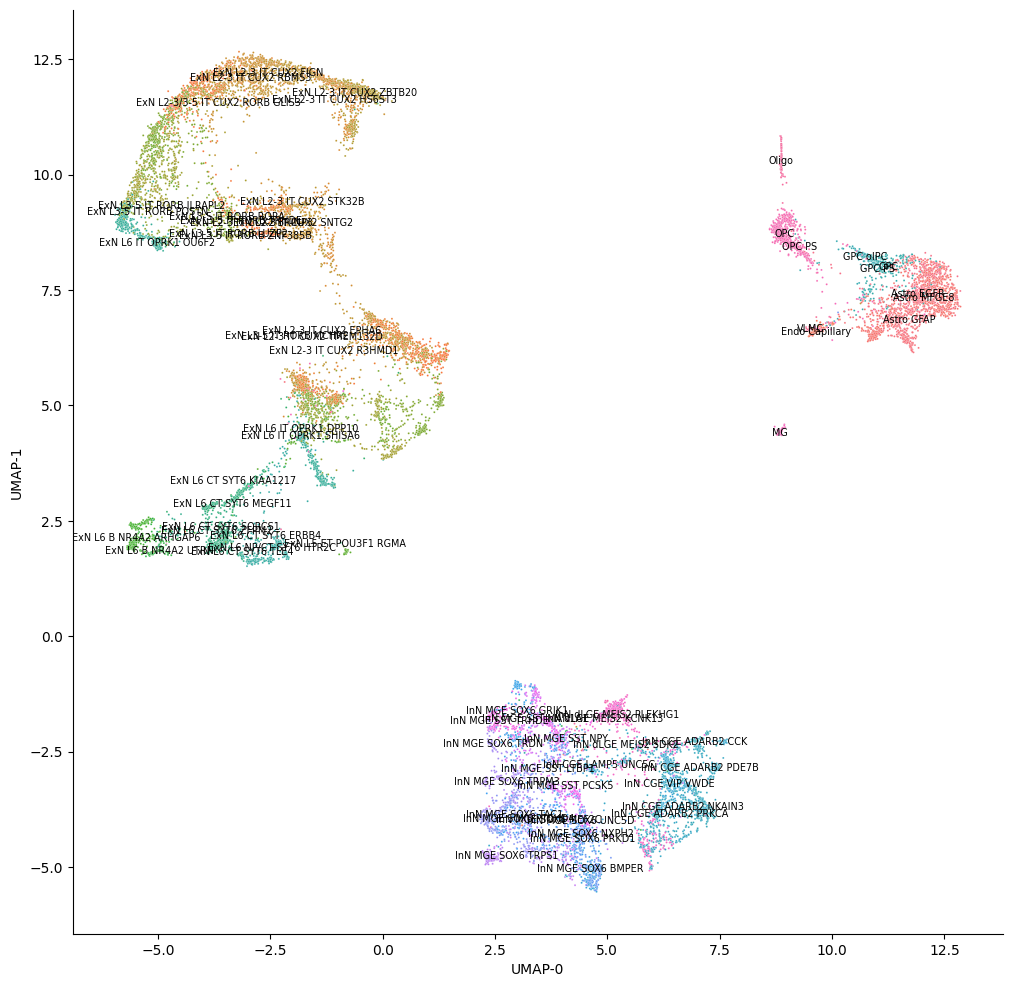

In [6]:
# Plot observed
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(sim_data_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = sim_data_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

## Visualize CellTRIP

In [7]:
# Reduce CellTRIP
steady_state_gex_embed = red.transform(steady_state_gex)  # np.concat([sim_data, steady_state_gex], axis=0)
steady_state_gex_embed = pd.DataFrame(steady_state_gex_embed, index=adata[sample_mask].obs_names, columns=[f'UMAP-{i}' for i in range(steady_state_gex_embed.shape[1])])
steady_state_gex_embed['subtype'] = adata.obs.loc[sample_mask, 'subtype']
steady_state_gex_embed['sample'] = adata.obs.loc[sample_mask, 'sample']
steady_state_gex_embed['source'] = 'CellTRIP'

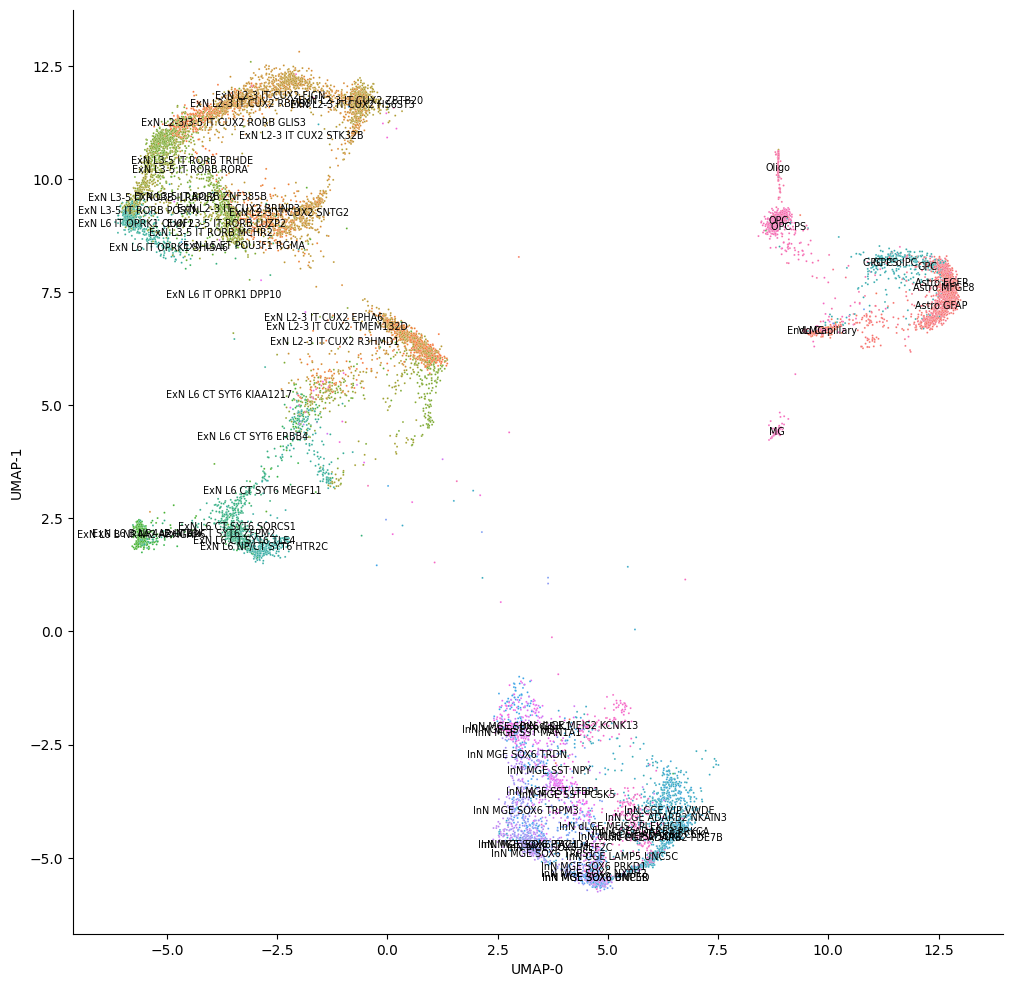

In [8]:
# Plot CellTRIP
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(steady_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = steady_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

## Visualize Training and Validation

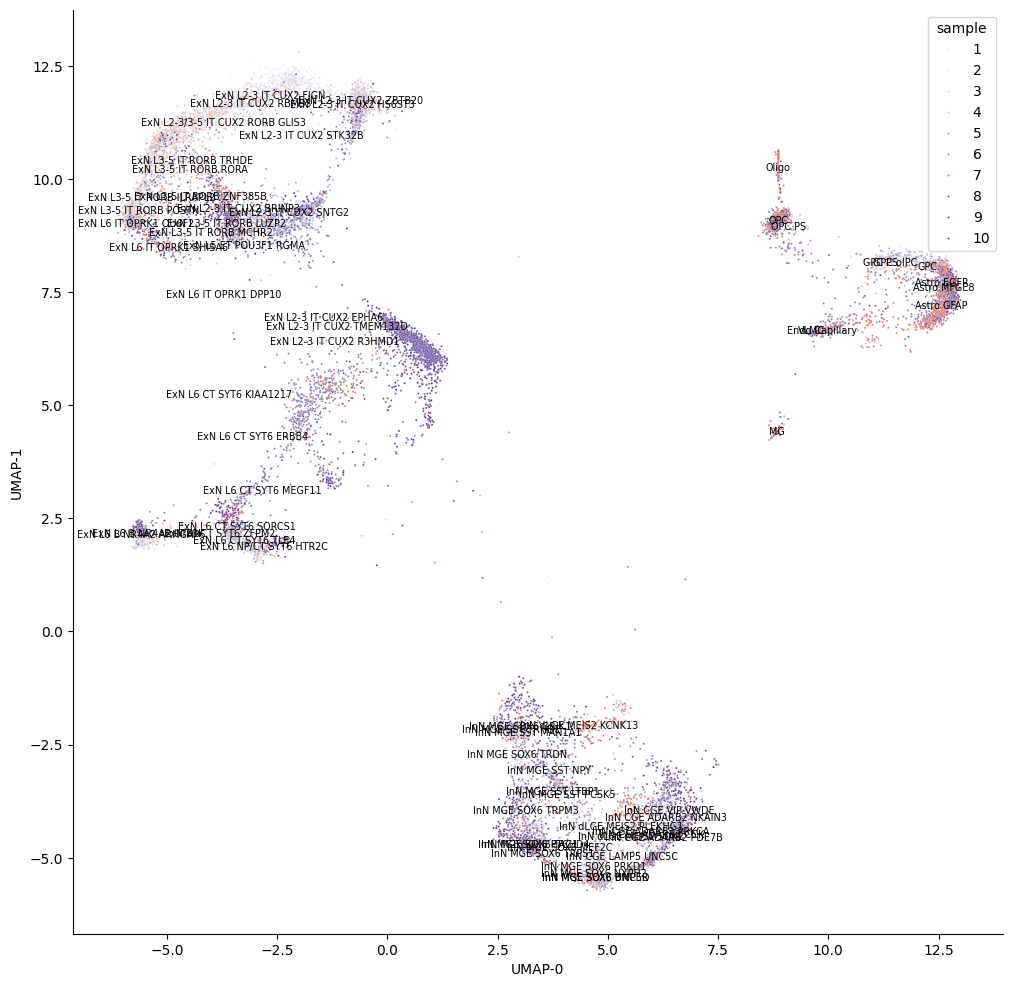

In [9]:
# Get colors
sample_train = adata.obs.groupby('sample')['Train'].max()
hue_order = sample_train.index.to_numpy()
palette = np.zeros((sample_train.shape[0], 3))
palette[sample_train] = sns.color_palette('Purples', sample_train.sum())
palette[~sample_train] = sns.color_palette('Reds', (~sample_train).sum())
# palette[:] = sns.color_palette('Purples', sample_train.shape[0])
palette = palette.tolist()
# Plot CellTRIP samples
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(steady_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='sample', hue_order=hue_order, palette=palette, s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = steady_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

## Visualize Observed and CellTRIP

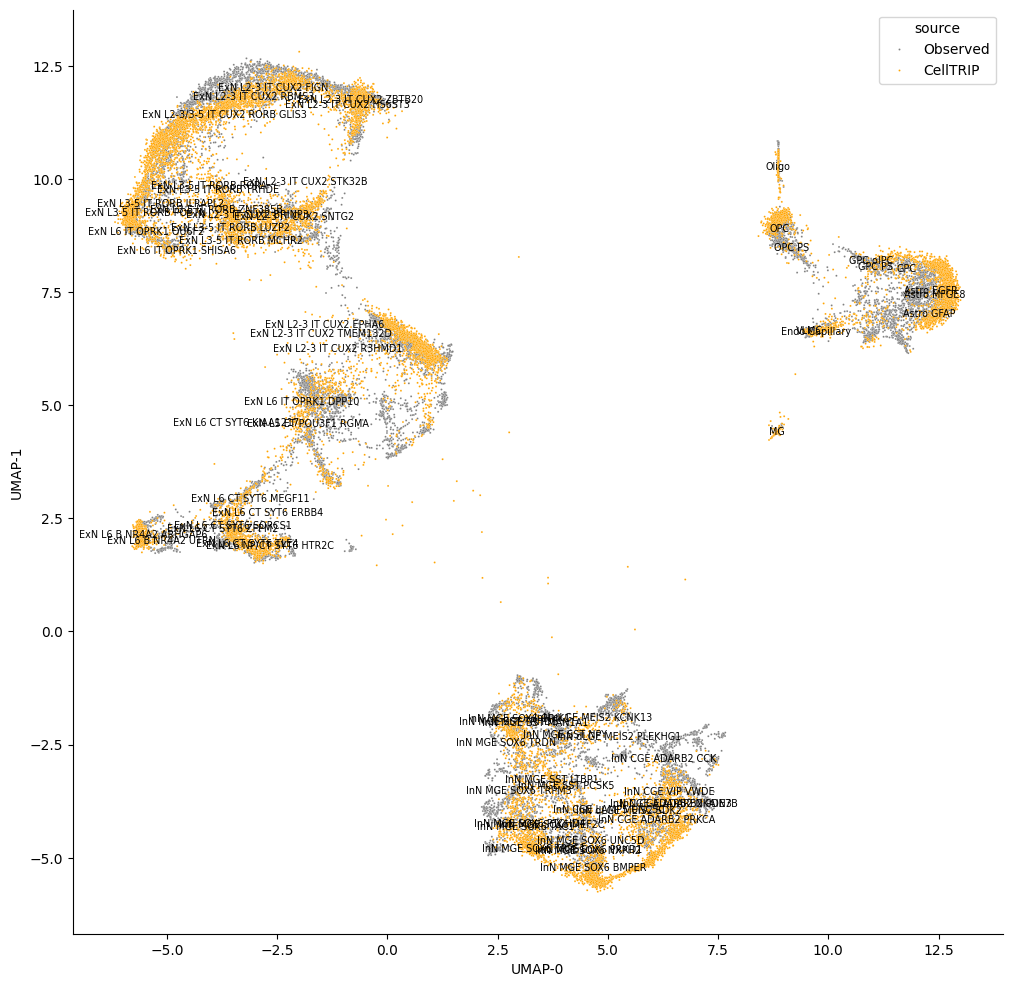

In [10]:
# Concatenate
concat_embed = pd.concat([sim_data_embed, steady_state_gex_embed], axis=0)

# Plot observed vs. CellTRIP
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(concat_embed, x='UMAP-0', y='UMAP-1', hue='source', palette=['gray', 'orange'], s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = concat_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

# Knock Down *RAPGEF4*

In [11]:
def knockdown(target_gene):
    # Get target gene
    gene_idx = [np.argmax(adata.var.index.to_numpy()==target_gene)]
    sim_time, skip_states = 128., 100.

    # Reset environment
    env.reset().set_max_time(sim_time)
    env.set_state(steady_state.to(env.device))
    ret = celltrip.train.simulate_until_completion(
        env, policy,
        env_hooks=[
            celltrip.utility.hooks.clamp_input_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0,
                device=env.device)
            # celltrip.utility.hooks.clamp_inverted_features_hook(
            #     gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[],
        skip_states=skip_states, store_states='cpu', progress_bar=True)

    # Impute last state
    knocked_state_pos = ret[-1][-1, ..., :env.dim]
    with torch.no_grad(): knocked_state_gex = policy.pinning[0](knocked_state_pos.to('cuda')).detach().cpu().numpy()
    knocked_state_gex, = preprocessing.inverse_transform(knocked_state_gex, subset_modality=0)

    return knocked_state_gex

target_gene = 'RAPGEF4'
knocked_state_gex = knockdown(target_gene)


0it [00:00, ?it/s]


2it [00:00, 19.01it/s]


5it [00:00, 20.80it/s]


8it [00:00, 21.17it/s]


11it [00:00, 21.39it/s]


14it [00:00, 21.52it/s]


17it [00:00, 21.61it/s]


20it [00:00, 21.66it/s]


23it [00:01, 21.70it/s]


26it [00:01, 21.71it/s]


29it [00:01, 21.71it/s]


32it [00:01, 21.72it/s]


35it [00:01, 21.74it/s]


38it [00:01, 21.75it/s]


41it [00:01, 21.82it/s]


44it [00:02, 21.86it/s]


47it [00:02, 21.90it/s]


50it [00:02, 21.91it/s]


53it [00:02, 21.92it/s]


56it [00:02, 21.94it/s]


59it [00:02, 21.94it/s]


62it [00:02, 21.95it/s]


65it [00:02, 21.96it/s]


68it [00:03, 21.95it/s]


71it [00:03, 21.96it/s]


74it [00:03, 21.94it/s]


77it [00:03, 21.96it/s]


80it [00:03, 21.94it/s]


83it [00:03, 21.96it/s]


86it [00:03, 21.96it/s]


89it [00:04, 21.96it/s]


92it [00:04, 21.97it/s]


95it [00:04, 21.90it/s]


98it [00:04, 21.91it/s]


101it [00:04, 21.90it/s]


104it [00:04, 21.92it/s]


107it [00:04, 21.92it/s]


110it [00:05, 21.94it/s]


113it [00:05, 21.94it/s]


116it [00:05, 21.94it/s]


119it [00:05, 21.93it/s]


122it [00:05, 21.93it/s]


125it [00:05, 21.95it/s]


128it [00:05, 21.96it/s]


131it [00:05, 21.95it/s]


134it [00:06, 21.96it/s]


137it [00:06, 21.96it/s]


140it [00:06, 21.96it/s]


143it [00:06, 21.96it/s]


146it [00:06, 21.94it/s]


149it [00:06, 21.95it/s]


152it [00:06, 21.88it/s]


155it [00:07, 21.89it/s]


158it [00:07, 21.91it/s]


161it [00:07, 21.92it/s]


164it [00:07, 21.94it/s]


167it [00:07, 21.94it/s]


170it [00:07, 21.94it/s]


173it [00:07, 21.95it/s]


176it [00:08, 21.96it/s]


179it [00:08, 21.88it/s]


182it [00:08, 21.89it/s]


185it [00:08, 21.91it/s]


188it [00:08, 21.94it/s]


191it [00:08, 21.89it/s]


194it [00:08, 21.91it/s]


197it [00:09, 21.94it/s]


200it [00:09, 21.93it/s]


203it [00:09, 21.95it/s]


206it [00:09, 21.95it/s]


209it [00:09, 21.99it/s]


212it [00:09, 21.98it/s]


215it [00:09, 21.98it/s]


218it [00:09, 21.99it/s]


221it [00:10, 21.99it/s]


224it [00:10, 21.99it/s]


227it [00:10, 21.99it/s]


230it [00:10, 22.00it/s]


233it [00:10, 21.99it/s]


236it [00:10, 21.99it/s]


239it [00:10, 21.97it/s]


242it [00:11, 21.99it/s]


245it [00:11, 21.99it/s]


248it [00:11, 21.97it/s]


251it [00:11, 21.97it/s]


254it [00:11, 21.97it/s]


257it [00:11, 21.95it/s]


260it [00:11, 21.96it/s]


263it [00:12, 21.96it/s]


266it [00:12, 21.98it/s]


269it [00:12, 21.98it/s]


272it [00:12, 21.98it/s]


275it [00:12, 21.99it/s]


278it [00:12, 21.97it/s]


281it [00:12, 21.96it/s]


284it [00:12, 21.97it/s]


287it [00:13, 21.97it/s]


290it [00:13, 21.98it/s]


293it [00:13, 21.96it/s]


296it [00:13, 21.97it/s]


299it [00:13, 21.94it/s]


302it [00:13, 21.95it/s]


305it [00:13, 21.96it/s]


308it [00:14, 21.97it/s]


311it [00:14, 21.91it/s]


314it [00:14, 21.92it/s]


317it [00:14, 21.94it/s]


320it [00:14, 21.96it/s]


323it [00:14, 21.95it/s]


326it [00:14, 21.97it/s]


329it [00:15, 21.97it/s]


332it [00:15, 21.97it/s]


335it [00:15, 21.98it/s]


338it [00:15, 21.99it/s]


341it [00:15, 21.98it/s]


344it [00:15, 22.00it/s]


347it [00:15, 21.99it/s]


350it [00:15, 21.98it/s]


353it [00:16, 21.99it/s]


356it [00:16, 22.01it/s]


359it [00:16, 22.00it/s]


362it [00:16, 21.99it/s]


365it [00:16, 22.00it/s]


368it [00:16, 21.97it/s]


371it [00:16, 21.98it/s]


374it [00:17, 21.96it/s]


377it [00:17, 21.93it/s]


380it [00:17, 21.94it/s]


383it [00:17, 21.96it/s]


386it [00:17, 21.97it/s]


389it [00:17, 21.95it/s]


392it [00:17, 21.97it/s]


395it [00:18, 21.99it/s]


398it [00:18, 21.99it/s]


401it [00:18, 21.96it/s]


404it [00:18, 21.98it/s]


407it [00:18, 21.96it/s]


410it [00:18, 21.96it/s]


413it [00:18, 21.97it/s]


416it [00:18, 21.98it/s]


419it [00:19, 22.00it/s]


422it [00:19, 22.01it/s]


425it [00:19, 22.00it/s]


428it [00:19, 22.01it/s]


431it [00:19, 21.98it/s]


434it [00:19, 21.98it/s]


437it [00:19, 21.97it/s]


440it [00:20, 21.97it/s]


443it [00:20, 21.97it/s]


446it [00:20, 21.96it/s]


449it [00:20, 21.97it/s]


452it [00:20, 21.97it/s]


455it [00:20, 21.93it/s]


458it [00:20, 21.95it/s]


461it [00:21, 21.95it/s]


464it [00:21, 21.97it/s]


467it [00:21, 21.96it/s]


470it [00:21, 21.98it/s]


473it [00:21, 21.98it/s]


476it [00:21, 21.97it/s]


479it [00:21, 21.96it/s]


482it [00:21, 21.97it/s]


485it [00:22, 21.97it/s]


488it [00:22, 21.96it/s]


491it [00:22, 21.96it/s]


494it [00:22, 21.97it/s]


497it [00:22, 21.97it/s]


500it [00:22, 21.94it/s]


503it [00:22, 21.95it/s]


506it [00:23, 21.97it/s]


509it [00:23, 21.96it/s]


512it [00:23, 21.95it/s]


515it [00:23, 21.98it/s]


518it [00:23, 21.97it/s]


521it [00:23, 21.96it/s]


524it [00:23, 21.94it/s]


527it [00:24, 21.96it/s]


530it [00:24, 21.95it/s]


533it [00:24, 21.95it/s]


536it [00:24, 21.97it/s]


539it [00:24, 21.97it/s]


542it [00:24, 21.98it/s]


545it [00:24, 22.00it/s]


548it [00:24, 22.00it/s]


551it [00:25, 22.00it/s]


554it [00:25, 21.97it/s]


557it [00:25, 21.97it/s]


560it [00:25, 21.97it/s]


563it [00:25, 21.98it/s]


566it [00:25, 21.96it/s]


569it [00:25, 21.98it/s]


572it [00:26, 21.99it/s]


575it [00:26, 21.97it/s]


578it [00:26, 21.97it/s]


581it [00:26, 21.97it/s]


584it [00:26, 21.98it/s]


587it [00:26, 21.98it/s]


590it [00:26, 21.99it/s]


593it [00:27, 22.00it/s]


596it [00:27, 22.00it/s]


599it [00:27, 21.99it/s]


602it [00:27, 21.97it/s]


605it [00:27, 21.98it/s]


608it [00:27, 21.99it/s]


611it [00:27, 21.99it/s]


614it [00:27, 22.01it/s]


617it [00:28, 22.01it/s]


620it [00:28, 22.00it/s]


623it [00:28, 21.99it/s]


626it [00:28, 21.98it/s]


629it [00:28, 21.98it/s]


632it [00:28, 21.96it/s]


635it [00:28, 21.96it/s]


638it [00:29, 21.97it/s]


641it [00:29, 21.95it/s]


644it [00:29, 21.96it/s]


647it [00:29, 21.96it/s]


650it [00:29, 21.96it/s]


653it [00:29, 21.95it/s]


656it [00:29, 21.95it/s]


659it [00:30, 21.96it/s]


662it [00:30, 21.95it/s]


665it [00:30, 21.95it/s]


668it [00:30, 21.96it/s]


671it [00:30, 21.97it/s]


674it [00:30, 21.98it/s]


677it [00:30, 21.98it/s]


680it [00:30, 21.98it/s]


683it [00:31, 21.98it/s]


686it [00:31, 21.99it/s]


689it [00:31, 21.99it/s]


692it [00:31, 21.98it/s]


695it [00:31, 21.99it/s]


698it [00:31, 21.99it/s]


701it [00:31, 21.97it/s]


704it [00:32, 21.96it/s]


707it [00:32, 21.96it/s]


710it [00:32, 21.96it/s]


713it [00:32, 21.95it/s]


716it [00:32, 21.95it/s]


719it [00:32, 21.96it/s]


722it [00:32, 21.97it/s]


725it [00:33, 21.98it/s]


728it [00:33, 21.99it/s]


731it [00:33, 21.97it/s]


734it [00:33, 21.97it/s]


737it [00:33, 21.96it/s]


740it [00:33, 21.97it/s]


743it [00:33, 21.97it/s]


746it [00:33, 21.98it/s]


749it [00:34, 21.98it/s]


752it [00:34, 21.96it/s]


755it [00:34, 21.95it/s]


758it [00:34, 21.95it/s]


761it [00:34, 21.96it/s]


764it [00:34, 21.97it/s]


767it [00:34, 21.97it/s]


770it [00:35, 21.98it/s]


773it [00:35, 21.98it/s]


776it [00:35, 21.99it/s]


779it [00:35, 21.99it/s]


782it [00:35, 21.99it/s]


785it [00:35, 21.96it/s]


788it [00:35, 21.97it/s]


791it [00:36, 21.97it/s]


794it [00:36, 21.95it/s]


797it [00:36, 21.95it/s]


800it [00:36, 21.95it/s]


803it [00:36, 21.95it/s]


806it [00:36, 21.95it/s]


809it [00:36, 21.96it/s]


812it [00:36, 21.97it/s]


815it [00:37, 21.97it/s]


818it [00:37, 21.95it/s]


821it [00:37, 21.94it/s]


824it [00:37, 21.94it/s]


827it [00:37, 21.95it/s]


830it [00:37, 21.95it/s]


833it [00:37, 21.96it/s]


836it [00:38, 21.96it/s]


839it [00:38, 21.93it/s]


842it [00:38, 21.94it/s]


845it [00:38, 21.95it/s]


848it [00:38, 21.96it/s]


851it [00:38, 21.97it/s]


854it [00:38, 21.97it/s]


857it [00:39, 21.97it/s]


860it [00:39, 21.97it/s]


863it [00:39, 21.97it/s]


866it [00:39, 21.95it/s]


869it [00:39, 21.96it/s]


872it [00:39, 21.96it/s]


875it [00:39, 21.96it/s]


878it [00:40, 21.96it/s]


881it [00:40, 21.94it/s]


884it [00:40, 21.94it/s]


887it [00:40, 21.94it/s]


890it [00:40, 21.95it/s]


893it [00:40, 21.95it/s]


896it [00:40, 21.96it/s]


899it [00:40, 21.97it/s]


902it [00:41, 21.95it/s]


905it [00:41, 21.93it/s]


908it [00:41, 21.93it/s]


911it [00:41, 21.94it/s]


914it [00:41, 21.95it/s]


917it [00:41, 21.94it/s]


920it [00:41, 21.96it/s]


923it [00:42, 21.96it/s]


926it [00:42, 21.93it/s]


929it [00:42, 21.94it/s]


932it [00:42, 21.94it/s]


935it [00:42, 21.95it/s]


938it [00:42, 21.94it/s]


941it [00:42, 21.93it/s]


944it [00:43, 21.95it/s]


947it [00:43, 21.95it/s]


950it [00:43, 21.94it/s]


953it [00:43, 21.96it/s]


956it [00:43, 21.97it/s]


959it [00:43, 21.97it/s]


962it [00:43, 21.96it/s]


965it [00:43, 21.97it/s]


968it [00:44, 21.96it/s]


971it [00:44, 21.94it/s]


974it [00:44, 21.96it/s]


977it [00:44, 21.96it/s]


980it [00:44, 21.94it/s]


983it [00:44, 21.95it/s]


986it [00:44, 21.95it/s]


989it [00:45, 21.97it/s]


992it [00:45, 21.96it/s]


995it [00:45, 21.95it/s]


998it [00:45, 21.96it/s]


1001it [00:45, 21.95it/s]


1004it [00:45, 21.95it/s]


1007it [00:45, 21.97it/s]


1010it [00:46, 21.97it/s]


1013it [00:46, 21.97it/s]


1016it [00:46, 21.98it/s]


1019it [00:46, 21.98it/s]


1022it [00:46, 21.97it/s]


1025it [00:46, 21.97it/s]


1028it [00:46, 21.97it/s]


1031it [00:46, 21.96it/s]


1034it [00:47, 21.97it/s]


1037it [00:47, 21.96it/s]


1040it [00:47, 21.96it/s]


1043it [00:47, 21.97it/s]


1046it [00:47, 21.98it/s]


1049it [00:47, 21.96it/s]


1052it [00:47, 21.97it/s]


1055it [00:48, 21.97it/s]


1058it [00:48, 21.96it/s]


1061it [00:48, 21.97it/s]


1064it [00:48, 21.96it/s]


1067it [00:48, 21.97it/s]


1070it [00:48, 21.96it/s]


1073it [00:48, 21.96it/s]


1076it [00:49, 21.95it/s]


1079it [00:49, 21.96it/s]


1082it [00:49, 21.94it/s]


1085it [00:49, 21.94it/s]


1088it [00:49, 21.96it/s]


1091it [00:49, 21.95it/s]


1094it [00:49, 21.96it/s]


1097it [00:49, 21.97it/s]


1100it [00:50, 21.96it/s]


1103it [00:50, 21.94it/s]


1106it [00:50, 21.95it/s]


1109it [00:50, 21.95it/s]


1112it [00:50, 21.94it/s]


1115it [00:50, 21.96it/s]


1118it [00:50, 21.96it/s]


1121it [00:51, 21.97it/s]


1124it [00:51, 21.97it/s]


1127it [00:51, 21.94it/s]


1130it [00:51, 21.96it/s]


1133it [00:51, 21.96it/s]


1136it [00:51, 21.95it/s]


1139it [00:51, 21.95it/s]


1142it [00:52, 21.95it/s]


1145it [00:52, 21.96it/s]


1148it [00:52, 21.96it/s]


1151it [00:52, 21.98it/s]


1154it [00:52, 21.97it/s]


1157it [00:52, 21.98it/s]


1160it [00:52, 21.97it/s]


1163it [00:52, 21.97it/s]


1166it [00:53, 21.98it/s]


1169it [00:53, 21.96it/s]


1172it [00:53, 21.97it/s]


1175it [00:53, 21.98it/s]


1178it [00:53, 21.97it/s]


1181it [00:53, 21.96it/s]


1184it [00:53, 21.97it/s]


1187it [00:54, 21.97it/s]


1190it [00:54, 21.96it/s]


1193it [00:54, 21.95it/s]


1196it [00:54, 21.96it/s]


1199it [00:54, 21.97it/s]


1202it [00:54, 21.93it/s]


1205it [00:54, 21.94it/s]


1208it [00:55, 21.94it/s]


1211it [00:55, 21.96it/s]


1214it [00:55, 21.95it/s]


1217it [00:55, 21.96it/s]


1220it [00:55, 21.96it/s]


1223it [00:55, 21.98it/s]


1226it [00:55, 21.99it/s]


1229it [00:55, 21.99it/s]


1232it [00:56, 21.98it/s]


1235it [00:56, 21.95it/s]


1238it [00:56, 21.97it/s]


1241it [00:56, 21.97it/s]


1244it [00:56, 21.97it/s]


1247it [00:56, 21.97it/s]


1250it [00:56, 21.97it/s]


1253it [00:57, 21.96it/s]


1256it [00:57, 21.95it/s]


1259it [00:57, 21.95it/s]


1262it [00:57, 21.97it/s]


1265it [00:57, 21.98it/s]


1268it [00:57, 21.95it/s]


1271it [00:57, 21.96it/s]


1274it [00:58, 21.93it/s]


1277it [00:58, 21.87it/s]


1280it [00:58, 21.88it/s]


1280it [00:58, 21.94it/s]

## Visualize Shift

In [12]:
# Reduce knocked
knocked_state_gex_embed = red.transform(knocked_state_gex)
knocked_state_gex_embed = pd.DataFrame(knocked_state_gex_embed, index=adata[sample_mask].obs_names, columns=[f'UMAP-{i}' for i in range(knocked_state_gex_embed.shape[1])])
knocked_state_gex_embed['subtype'] = adata.obs.loc[sample_mask, 'subtype']
knocked_state_gex_embed['sample'] = adata.obs.loc[sample_mask, 'sample']
knocked_state_gex_embed['source'] = 'CellTRIP Knockdown'

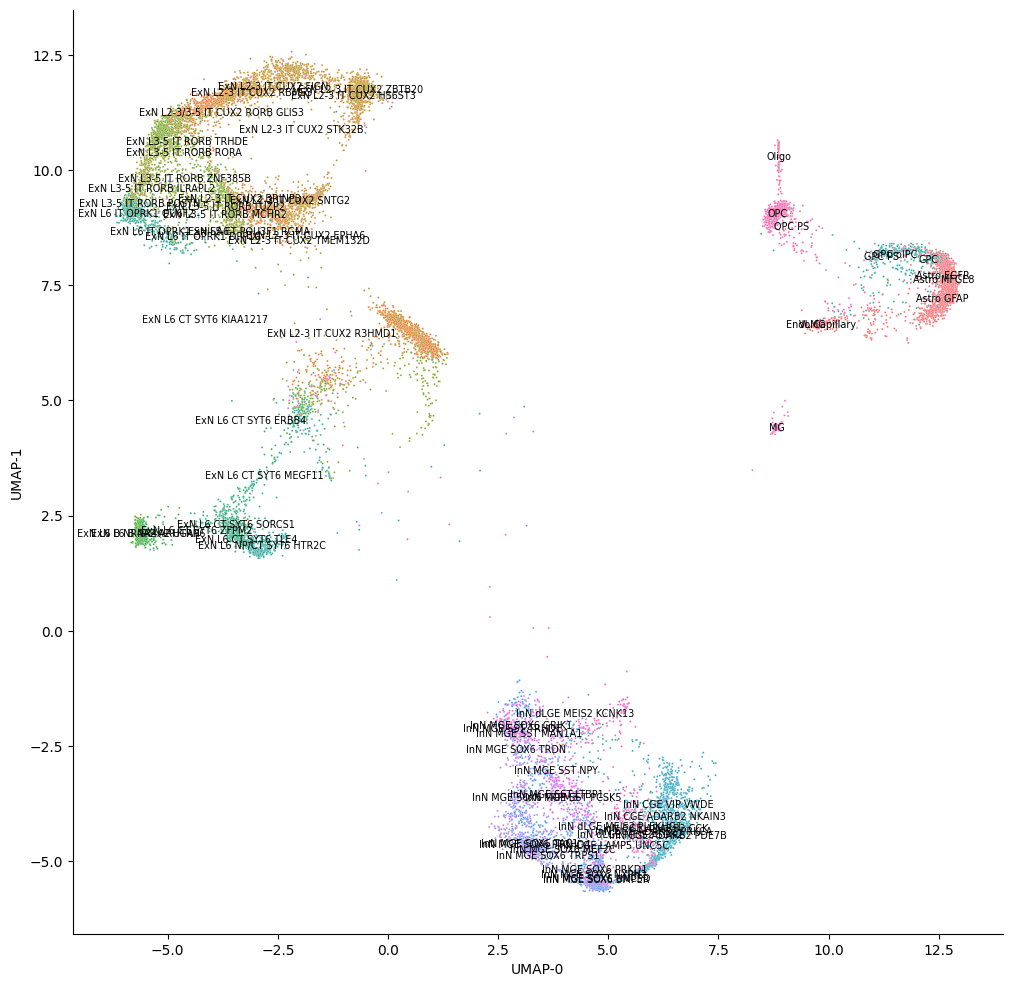

In [13]:
# Plot CellTRIP knockdown
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(knocked_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = knocked_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

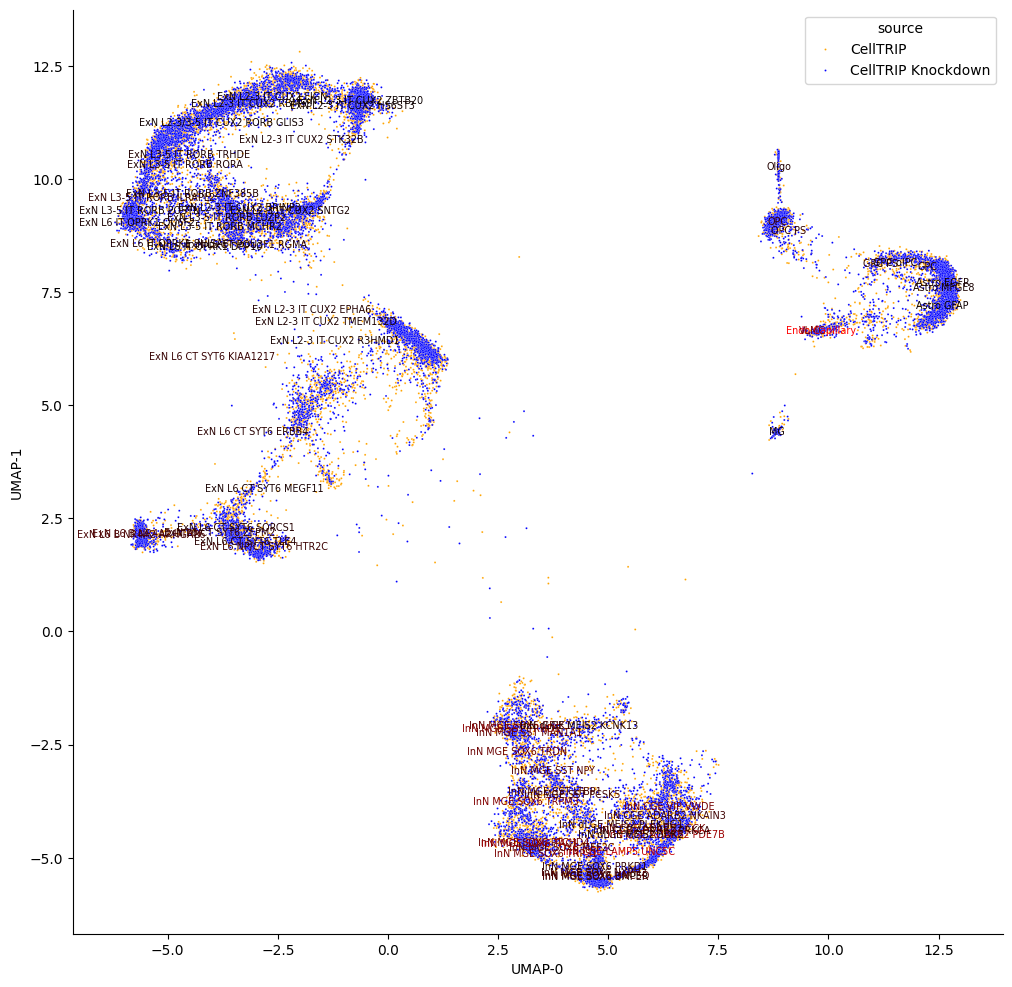

In [14]:
# Get mean subtype deviation
# diff = pd.DataFrame(knocked_state_gex - steady_state_gex, index=adata[sample_mask].obs_names, columns=adata[sample_mask].var_names)
diff = pd.DataFrame(index=adata[sample_mask].obs_names)
diff['Distance'] = np.sqrt(np.square(knocked_state_gex - steady_state_gex).mean(axis=1))
diff['subtype'] = adata[sample_mask].obs['subtype']
subtype_diff = diff.groupby('subtype', observed=True).mean()
subtype_alpha = (subtype_diff / subtype_diff.max())['Distance']

# Concatenate
concat_embed = pd.concat([steady_state_gex_embed, knocked_state_gex_embed], axis=0)

# Plot CellTRIP vs. CellTRIP knockdown
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(concat_embed, x='UMAP-0', y='UMAP-1', hue='source', palette=['orange', 'blue'], s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = concat_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(
        *r.to_numpy(), subtype,
        ha='center', va='center', fontsize='x-small',
        color=[subtype_alpha.loc[subtype], 0, 0],
        transform=ax.transData)

<Axes: xlabel='subtype', ylabel='Gene'>

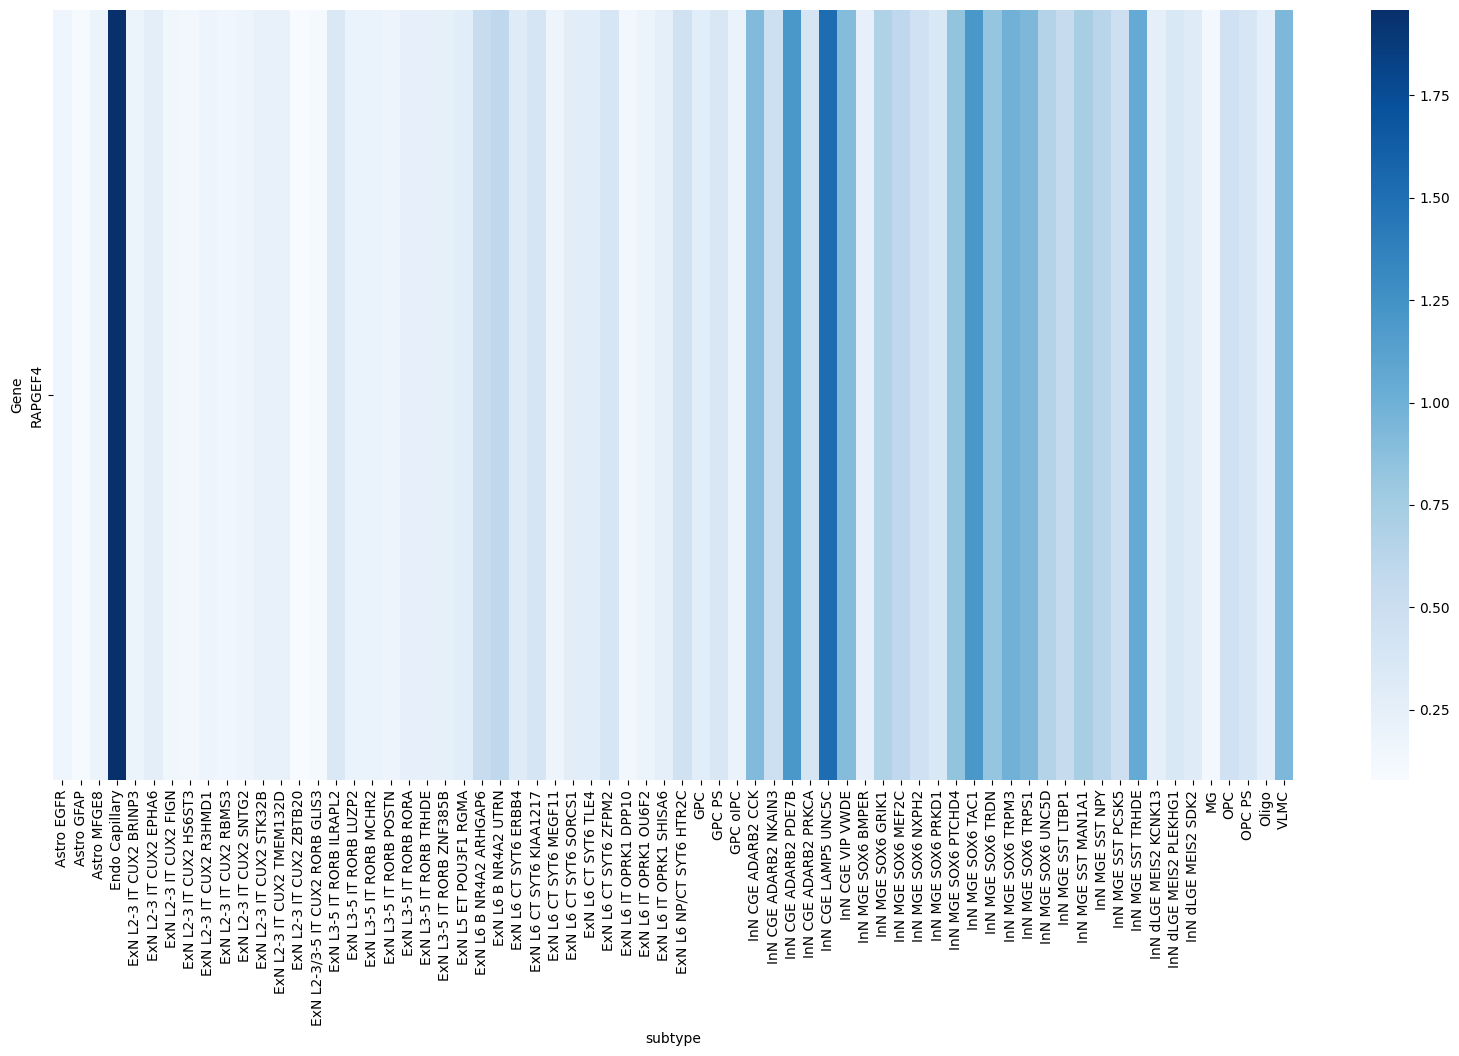

In [15]:
# Format df
df = subtype_diff.reset_index()
df['Gene'] = target_gene
df = df.pivot(index='Gene', columns='subtype', values='Distance')
# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(df, cmap='Blues', ax=ax)

In [ ]:
df

subtype,Astro EGFR,Astro GFAP,Astro MFGE8,Endo Capillary,ExN L2-3 IT CUX2 BRINP3,ExN L2-3 IT CUX2 EPHA6,ExN L2-3 IT CUX2 FIGN,ExN L2-3 IT CUX2 HS6ST3,ExN L2-3 IT CUX2 R3HMD1,ExN L2-3 IT CUX2 RBMS3,...,InN MGE SST PCSK5,InN MGE SST TRHDE,InN dLGE MEIS2 KCNK13,InN dLGE MEIS2 PLEKHG1,InN dLGE MEIS2 SDK2,MG,OPC,OPC PS,Oligo,VLMC
Gene,,,,,,,,,,,,,,,,,,,,,
RAPGEF4,0.179536,0.117602,0.154775,2.150513,0.195777,0.262073,0.147484,0.132958,0.1903,0.143911,...,0.46849,1.020384,0.324457,0.418723,0.297595,0.097145,0.4559,0.396561,0.248769,0.762757
